In [ ]:
from mygene import MyGeneInfo
import pandas as pd
import pyreadr
import os
import importlib
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import numpy as np
import requests
import harmonypy as hm
from inmoose.pycombat import pycombat_norm, pycombat_seq
import matplotlib.pyplot as plt
import math, re
from scipy.stats import levene

from sklearn.neighbors import NearestNeighbors
from scipy.stats import gmean
import gseapy as gp
from TMEImmune import TME_score
from tidepy.pred import TIDE
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import fisher_exact, mannwhitneyu, spearmanr
import matplotlib.font_manager as fm
import seaborn as sns
import sklearn
sklearn.set_config(transform_output="pandas")
import category_encoders as ce
from statannotations.Annotator import Annotator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from matplotlib_venn import venn2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

### functions

In [1735]:
def normalize_row(row):
    min_val = row.min()
    max_val = row.max()
    # Avoid division by zero for constant rows
    if min_val == max_val:
        return row
    return (row - min_val) / (max_val - min_val)

def two_step_norm(df):
    df_norm = (df - df.min())/(df.max() - df.min())
    df_norm1 = df_norm.apply(normalize_row, axis = 1)
    return df_norm1


def remove_empty_row(df, threshold = 1e-8, empty_rate = 1/5):

    condition_mask = df < threshold
    problem_count = condition_mask.sum(axis=1)
    total_values = df.shape[1]
    rows_to_remove = problem_count > total_values*empty_rate
    df1 = df.loc[~rows_to_remove].copy()
    return df1

def data_prep(gene, clin):
    common_sample = list(set(clin.index) & set(gene.columns))
    gene1 = gene[common_sample]
    clin1 = clin.loc[common_sample]
    gene_norm = two_step_norm(gene1)
    return gene_norm, clin1

def compute_entropy(data_expression_df, labels):
    nbrs = NearestNeighbors(n_neighbors = 10, metric="euclidean").fit(
        data_expression_df.T
    )
    _, indices = nbrs.kneighbors(data_expression_df.T)
    batch_labels = labels

    entropies = []
    for index in indices:
        neighbors_labels = batch_labels[index]
        label_counts = np.unique(neighbors_labels, return_counts=True)[1]
        probabilities = label_counts / len(neighbors_labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        entropies.append(entropy)

    return np.mean(entropies)

def batch_correction(df, batch, method = "combat", batch_name = None): # method: combat, bbknn
    if method == "combat":
        df_corrected = pycombat_norm(df, batch)
    else:  ## harmony
        if batch_name is None:
            ho = hm.run_harmony(df, pd.DataFrame(batch), [0])
        else:
            ho = hm.run_harmony(df, pd.DataFrame(batch), [batch_name])
        df_corrected = pd.DataFrame(ho.Z_corr, columns = df.columns, index = df.index)
    return df_corrected

def batch_effect_comparison(df_before, df_combat, df_harmony, df_scbatch, batch, name):
    
    X1 = df_before.T.values
    X21 = df_combat.T.values
    X22 = df_harmony.T.values
    X23 = df_scbatch.T.values
    n_pc = len(set(batch))
    batch = np.array(batch)

    # 1) PCA for original data
    pca = PCA(n_components=n_pc, random_state = 123)
    X1_pca = np.asarray(pca.fit_transform(X1))
    entropy_before = compute_entropy(df_before, batch)

    # 2) PCA for combat
    X21_pca = np.asarray(pca.fit_transform(X21))
    entropy_combat = compute_entropy(df_combat, batch)

    X22_pca = np.asarray(pca.fit_transform(X22))
    entropy_harmony = compute_entropy(df_harmony, batch)

    X23_pca = np.asarray(pca.fit_transform(X23))
    entropy_scbatch = compute_entropy(df_scbatch, batch)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    for lab in np.unique(batch):
        idx = batch == lab
        axes[0].scatter(X1_pca[idx, 0],
                        X1_pca[idx, 1],
                        label=lab, alpha=0.7)
        axes[1].scatter(X21_pca[idx, 0],
                        X21_pca[idx, 1],
                        label=lab, alpha=0.7)
        axes[2].scatter(X22_pca[idx, 0],
                        X22_pca[idx, 1],
                        label=lab, alpha=0.7)
        axes[3].scatter(X23_pca[idx, 0],
                        X23_pca[idx, 1],
                        label=lab, alpha=0.7)

    axes[0].set_title('PCA Before')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_xlim(-100,100)
    axes[0].text(0.05, 0.95, f'Mean Entropy: {entropy_before:.4f}', transform=axes[0].transAxes, va="top")

    axes[1].set_title('PCA After ComBat')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].set_xlim(-100,100)
    axes[1].text(0.05, 0.95, f'Mean Entropy: {entropy_combat:.4f}', transform=axes[1].transAxes, va="top")

    axes[2].set_title('PCA After Harmony')
    axes[2].set_xlabel('PC1')
    axes[2].set_ylabel('PC2')
    axes[2].set_xlim(-100,100)
    axes[2].text(0.05, 0.95, f'Mean Entropy: {entropy_harmony:.4f}', transform=axes[2].transAxes, va="top")

    axes[3].set_title('PCA After Scbatch')
    axes[3].set_xlabel('PC1')
    axes[3].set_ylabel('PC2')
    axes[3].set_xlim(-100,100)
    axes[3].text(0.05, 0.95, f'Mean Entropy: {entropy_scbatch:.4f}', transform=axes[3].transAxes, va="top")

    # Shared legend
    fig.subplots_adjust(right=0.75)
    fig.legend(np.unique(batch), title=name, bbox_to_anchor=(1.22, 0.9))
    plt.tight_layout()
    plt.show()

def map_index_id(df, merge_df, id2symbol = False):
    if not id2symbol:
        df1 = df.merge(merge_df, left_index = True, right_on = 'symbol', how = "inner")
        df1.index = df1['entrez_id']
        df1 = df1.drop(columns = ['symbol', 'entrez_id'])
    else:
        df1 = df.merge(merge_df, left_index = True, right_on = 'entrez_id', how = "inner")
        df1.index = df1['symbol']
        df1 = df1.drop(columns = ['symbol', 'entrez_id'])
    return df1

def get_geomean_score(df, sig, name = None):
    missing = set(sig) - set(df.index)
    if not missing:
        sig_df = df.loc[sig]
    else:
        common_sig = list(set(sig) & set(df.index))
        sig_df = df.loc[common_sig]
        print(f"{name}: {missing} not in dataframe")
    
    gmeans = sig_df.apply(lambda row: gmean(row), axis=0)
    return gmeans


def get_avgmean_score(df, sig, name = None):
    missing = set(sig) - set(df.index)
    if not missing:
        sig_df = df.loc[sig]
    else:
        common_sig = list(set(sig) & set(df.index))
        sig_df = df.loc[common_sig]
        print(f"{name}: {missing} not in dataframe")
    
    avgmeans = sig_df.mean(axis = 0)
    return avgmeans

def get_ratio_score(df, sig, name = None):
    numerator = sig[1]
    denominator = sig[0]
    if denominator not in df.index:
        print(f"{name}: denominator does not exist")
        ratio_score = pd.Series(None, index=df.columns, dtype=int)
        #raise ValueError("denominator does not exist")
    elif numerator not in df.index:
        ratio_score = pd.Series(0, index=df.columns, dtype=int)
    else:
        ratio_score = df.loc[numerator]/df.loc[denominator]
    return ratio_score

def get_impres_score(df, sig, name = None):
    Gene1 = sig['Gene1']
    Gene2 = sig['Gene2']
    missing = set(Gene1 + Gene2) - set(df.index)
    scores = pd.Series(0, index=df.columns, dtype=int)
    if missing:
        print(f"{name}: these genes are missing: {missing}")

    for g1, g2 in zip(Gene1, Gene2):
        g1_in = g1 in df.index
        g2_in = g2 in df.index
        if g1_in and g2_in:
            scores += (df.loc[g1] > df.loc[g2]).astype(int)
        elif g1_in and not g2_in:
            scores += 1
        elif g2_in and not g1_in:
            continue
        else:
            continue
    return scores

def get_ssgsea_score(df, sig):
    ss = gp.ssgsea(data=df,gene_sets=sig,min_size=1,outdir=None,verbose=True,sample_norm_method = "rank")
    score = ss.res2d[['Name', 'NES']]
    score.index = score['Name']
    score = score.drop(columns = 'Name')
    return score


def fit_coxph(score, event = "os_event", time = "os_months",name = None, merge_type = None,
              tcga = False, tcga_source = None): 
    # merge_type: cancer, treatment, tumor_type
    score_cols = ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']
    if not tcga:
        full_df1 = score.dropna(subset=[event,time, 'gender', 'age'])
        full_df1['gender1'] = full_df1['gender'].apply(lambda x: 1 if x == "M" else 0)
        columns = ['source', 'tumor_type', 'cancer', 'gender', 'treatment']
        full_df1 = full_df1.rename(columns = {"tumor type": "tumor_type"})
        cat_cols = [c for c in columns if full_df1[c].dropna().nunique() > 1]
        single_level_col = set(columns) - set(cat_cols)
        if set(["cancer", "tumor_type", 'treatment']).issubset(single_level_col):
            print(f"{name}: fitting univariate coxph")
        if single_level_col:
            print(f"{name} : {single_level_col} are dropped because they only have one level")
        encoder = ce.CountEncoder(cols=cat_cols)  # use frequency to encode the categorical variable
        encoder.fit(full_df1[cat_cols], full_df1[event])
        var_df = encoder.transform(full_df1[cat_cols])
        scaler = MinMaxScaler(feature_range=(0,1))
        var_df = scaler.fit_transform(var_df)
        cols = score_cols + [event, time, 'age', 'gender1']
        full_df2 = pd.concat([var_df, full_df1[cols]], axis = 1, join = "inner")
        full_df2[event] = full_df2[event].astype(int)
        full_df2['age'] = full_df2['age'].astype(int)
    else:
        full_df1 = score.dropna(subset=[time, event, 'age', 'gender', 'tumor_type', tcga_source])
        full_df1['gender1'] = full_df1['gender'].apply(lambda x: 1 if x == "male" else 0)
        columns = [tcga_source, 'tumor_type']
        encoder = ce.CountEncoder(cols=columns)  # use frequency to encode the categorical variable
        encoder.fit(full_df1[columns], full_df1[event])
        var_df = encoder.transform(full_df1[columns])
        cols = score_cols + [event, time, 'age', 'gender1']
        full_df2 = pd.concat([var_df, full_df1[cols]], axis = 1, join = "inner")
        full_df2[event] = full_df2[event].astype(int)
        full_df2['age'] = full_df2['age'].astype(int)
    cox_models = {}
    cindex = {}
    best_cindex = 0
    for col in score_cols:
        full_df3 = full_df2.drop(columns = [s for s in score_cols if s != col])
        full_df3 = full_df3[~full_df3[col].isna()]
        full_df3 = full_df3[np.isfinite(full_df3[col])]
        # corr = full_df3.corr().abs()
        # # mask out the diagonal
        # np.fill_diagonal(corr.values, 0)
        # perfect = np.where(corr == 1)
        # pairs = [(corr.index[i], corr.columns[j]) for i,j in zip(*perfect)]
        # to_drop = {b for (_, b) in pairs}
        # full_df4 = full_df3.drop(columns = list(to_drop))
        if merge_type:
            cph = CoxPHFitter(penalizer=1e-4, l1_ratio = 0.9)
            cph.fit(full_df3, 
                duration_col=time, event_col=event, show_progress=False)
        else:
            cph = CoxPHFitter(penalizer=1e-4, l1_ratio = 0.9)
            cph.fit(full_df3[[event, time, col]], duration_col = time, event_col = event, show_progress = False)

        cox_models[col] = cph
        cindex[col] = cph.concordance_index_
        if cph.concordance_index_ > best_cindex:
            best_cindex = cph.concordance_index_
    keys = [k for k, v in cindex.items() if v == best_cindex]
    vals = np.array(list(cindex.values()))
    var_pop = np.var(vals)  ## variance of the c-index
    print(f"{name} : {keys} have the highest c-index in coxph, the best c-index = {best_cindex:.4f}, variance = {var_pop:.4f}")
    return cox_models, cindex, var_pop

def extract_cox_summary(cox_df, cindex, form = "multivariate"):
    all_tables = {}
    score_cols = ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']
    for score in score_cols:
        summary_table = cox_df[score].summary
        summary_table['score'] = score
        summary_table['c-index'] = cindex
        summary_table['regression'] = form
        all_tables[score] = summary_table
    all_tables_df = pd.concat(all_tables, axis = 0)
    return all_tables_df

def remove_outlier(df, identical = False):
    df1 = df.copy()
    for col in df1.columns:
        df1[col] = df1[col].astype(float)
        Q3 = df1[col].quantile(0.75)
        Q1 = df1[col].quantile(0.25)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5* IQR
        outlier_mask = (df1[col] >= upper) | (df1[col] <= lower)
        df1.loc[outlier_mask, col] = None
        removed = outlier_mask.sum()
        if identical:
            if col in ['TLS', 'IFNr']:
                rounded = df1.copy()
                name = "round_"+col
                rounded[name] = rounded[col].round(3)
                filtered = rounded.drop_duplicates(subset=[name])
                filtered = filtered.drop(columns=[name])
                samples = list(set(rounded.index) - set(filtered.index))
                df1.loc[samples, col] = None
                removed += rounded.shape[0] - filtered.shape[0]
        print(f"{removed} outliers detected for {col}")
    return df1

In [3]:
### query entrez id DO NOT DELETE!!!!!
# complete_gene_list = list(set(hugo_gene.index) | set(cui_gene.index) | set(va_gene.index) | set(braun_gene.index) | set(miao_gene.index) | set(dam_gene.index) | set(rose_gene.index))
# mg = MyGeneInfo()
# symbols = complete_gene_list
# def chunker(seq, size):
#     for start in range(0, len(seq), size):
#         yield seq[start:start + size]
# first_chunk = True
# for chunk in chunker(symbols, 1000):
#     try:
#         results = mg.querymany(chunk, scopes="symbol", fields="entrezgene", species="human", as_dataframe=True, df_index=False)
#         symbol2id_df = results[["query", "entrezgene"]]
#         symbol2id_df.columns = ["symbol", "entrez_id"]

#         symbol2id_df.to_csv("symbol2entrez1.csv", mode="a", header=first_chunk, index=False, encoding="utf-8")
#         first_chunk = False

#     except Exception as e:
#         print(f"Batch starting at {chunk[0]} failed: {e}")

## map symbol to entrez id
symbol2id = pd.read_csv("symbol2entrez.csv")
symbol2id1 = symbol2id[~symbol2id['entrez_id'].isna()]
symbol2id1['entrez_id'] = symbol2id1['entrez_id'].apply(lambda x: int(x))

### prep data (match with clin, 2 step norm)

#### nsclc

In [1285]:
## jung nsclc: only has clinical benefit
# jung_gene = pd.read_table("Jung/jung_gene.tsv", index_col = 0)
# jung_clin = pd.read_excel("Jung/jung_clin.xlsx", sheet_name=0)

# jung_clin['ID'] = jung_clin['Patient ID'].apply(lambda x: "NSCLC" + str(x))
# jung_clin['source'] = 'jung'
# jung_gene1 = map_index_id(jung_gene, symbol2id1)
# jung_gene_norm, jung_clin1 = data_prep(jung_gene, jung_clin)

## ravi nsclc: all have response
ravi_gene = pd.read_excel("ravi_norm.xlsx", sheet_name=0, index_col=0)
ravi_clin = pd.read_excel("ravi_norm.xlsx", sheet_name=1, index_col=0)
ravi_gene1 = remove_empty_row(ravi_gene)
ravi_clin['clinical_benefit'] = ravi_clin['Harmonized_Confirmed_BOR'].apply(lambda x: 1 if x in ['PR','CR','SD'] else 0)
ravi_clin['resp'] = ravi_clin['Harmonized_Confirmed_BOR'].apply(lambda x: 1 if x in ['PR','CR', 'SD'] else 0)
ravi_gene2 = map_index_id(ravi_gene1, symbol2id1)
ravi_gene2 = ravi_gene2.loc[~ravi_gene2.index.duplicated(keep='first')]
ravi_gene_norm, ravi_clin1 = data_prep(ravi_gene2, ravi_clin)
ravi_clin1['source'] = 'ravi'
ravi_clin1['os_months'] = ravi_clin1['Harmonized_OS_Days']/30
ravi_clin1['pfs_months'] = ravi_clin1['Harmonized_PFS_Days']/30
ravi_clin2 = ravi_clin1[['clinical_benefit', 'source', 'os_months', 'Patient_Sex', 'Patient_Age_at_Diagnosis', 'Harmonized_OS_Event', 'pfs_months', 'Harmonized_PFS_Event', 'resp']]
ravi_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']
ravi_gene_norm1 = map_index_id(ravi_gene_norm, symbol2id1, id2symbol = True)

## foy nsclc
foy_nsclc_gene = pd.read_table("foy_nsclc/foy_gene.tsv", index_col = 0)
foy_nsclc_clin = pd.read_csv("foy_nsclc/foy_clin.csv", index_col="!Sample_geo_accession")
foy_nsclc_clin = foy_nsclc_clin[~foy_nsclc_clin['BOR'].isna()]
foy_nsclc_clin['clinical_benefit'] = foy_nsclc_clin['BOR'].apply(lambda x: 1 if x in ['PR','CR','SD'] else 0)
foy_nsclc_clin['resp'] = foy_nsclc_clin['BOR'].apply(lambda x: 1 if x in ['PR','CR', 'SD'] else 0)
foy_nsclc_gene1 = remove_empty_row(foy_nsclc_gene)
foy_nsclc_gene1 = foy_nsclc_gene1.loc[~foy_nsclc_gene1.index.duplicated(keep='first')]
foy_nsclc_gene_norm, foy_nsclc_clin1 = data_prep(foy_nsclc_gene1, foy_nsclc_clin)
foy_nsclc_gene_norm1 = map_index_id(foy_nsclc_gene_norm, symbol2id1, id2symbol = True)

#### ccrcc

In [1286]:
## braun ccrcc
braun_gene = pd.read_excel("braun_norm.xlsx", sheet_name=0, index_col=0)
braun_clin = pd.read_excel("braun_norm.xlsx", sheet_name=1, index_col=0)
braun_clin['clinical_benefit'] = braun_clin['Benefit'].apply(lambda x: 1 if x == "CB" else 0)
braun_gene1 = remove_empty_row(braun_gene, empty_rate = 1/5)
braun_gene2 = map_index_id(braun_gene1, symbol2id1)
braun_gene2 = braun_gene2.loc[~braun_gene2.index.duplicated(keep='first')]
braun_gene_norm, braun_clin1 = data_prep(braun_gene2, braun_clin)
braun_clin1['source'] = 'Braun'
braun_clin1['resp'] = braun_clin1['ORR'].apply(lambda x: 1 if x in ['CRPR', 'PR', 'CR', 'SD'] else 0)
braun_clin2 = braun_clin1[['clinical_benefit', 'source', 'OS', 'Sex', 'Age', 'delta', 'PFS', 'delta_pfs', 'resp']]
braun_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']
# braun_gene_primary_norm, braun_clin_primary = data_prep(braun_gene2, 
#                                                         braun_clin[braun_clin['Tumor_Sample_Primary_or_Metastasis'] == 'PRIMARY'])
# braun_gene_primary_norm1 = map_index_id(braun_gene_primary_norm, symbol2id1, id2symbol = True)
# braun_gene_met_norm, braun_clin_met = data_prep(braun_gene2, 
#                                                 braun_clin[braun_clin['Tumor_Sample_Primary_or_Metastasis'] == 'METASTASIS'])
# braun_clin_primary['source'] = 'braun primary'
# braun_clin_primary['resp'] = braun_clin_primary['ORR'].apply(lambda x: 1 if x in ['CRPR', 'PR', 'CR'] else 0)
# braun_clin_primary1 = braun_clin_primary[['clinical_benefit', 'source', 'OS', 'Sex', 'Age', 'delta', 'PFS', 'delta_pfs', 'resp']]
# braun_clin_primary1.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']
# braun_clin_met['source'] = 'braun met'
# braun_clin_met['resp'] = braun_clin_met['ORR'].apply(lambda x: 1 if x in ['CRPR', 'PR', 'CR'] else 0)
# braun_clin_met1 = braun_clin_met[['clinical_benefit', 'source', 'OS', 'Sex', 'Age', 'delta', 'PFS', 'delta_pfs', 'resp']]
# braun_clin_met1.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']


## miao
# miao_gene = pd.read_excel("miao_norm.xlsx", sheet_name=0, index_col=0)
# miao_clin = pd.read_excel("miao_norm.xlsx", sheet_name=1, index_col=0)
# miao_gene1 = remove_empty_row(miao_gene, empty_rate = 1/2)
# miao_clin['clinical_benefit'] = miao_clin['response_category'].apply(lambda x: 1 if x == "clinical benefit" else 0)
# miao_gene2 = map_index_id(miao_gene1, symbol2id1)
# miao_gene2 = miao_gene2.loc[~miao_gene2.index.duplicated(keep='first')]
# miao_gene_norm, miao_clin1 = data_prep(miao_gene2, miao_clin)
# miao_clin1['source'] = 'miao'
# miao_clin1['os_months'] = miao_clin1['os_days']/30
# miao_clin1['pfs_months'] = miao_clin1['pfs_days']/30
# miao_clin2 = miao_clin1[['clinical_benefit', 'source', 'os_months', 'sex', 'age', 'os_censor', 'pfs_months', 'pfs_censor', 'resp']]
# miao_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']

#### melanoma

In [ ]:
## hugo melanoma
hugo_gene = pd.read_excel("hugo_norm.xlsx", sheet_name=0, index_col=0)
hugo_clin = pd.read_excel("hugo_norm.xlsx", sheet_name=1, index_col=0)
hugo_clin['clinical_benefit'] = hugo_clin['irRECIST'].apply(lambda x: 
                                                             1 if x in ['Partial Response', 'Complete Response'] else 0)
hugo_clin['resp'] = hugo_clin['irRECIST'].apply(lambda x: 1 if x in ['Partial Response', 
                                                                     'Complete Response', 'Stable Disease'] else 0)
hugo_gene1 = map_index_id(hugo_gene, symbol2id1)
hugo_gene1 = hugo_gene1.loc[~hugo_gene1.index.duplicated(keep='first')]
hugo_gene_norm, hugo_clin1 = data_prep(hugo_gene1, hugo_clin)
hugo_clin1['os_months'] = hugo_clin1['Overall Survival']/30
hugo_clin2 = hugo_clin1[['clinical_benefit', 'batch', 'os_months', 'Gender', 'Age', 'delta', 'resp']]
hugo_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'resp']

## riaz melanoma
# riaz_gene = pd.read_excel("riaz_norm.xlsx", sheet_name=0, index_col=0)
# riaz_clin = pd.read_excel("riaz_norm.xlsx", sheet_name=1, index_col=0)
# riaz_clin['clinical_benefit'] = riaz_clin['Response'].apply(lambda x: 1 if x in ['PR','CR','SD'] else 0)
# riaz_gene_norm, riaz_clin1 = data_prep(riaz_gene, riaz_clin)
# riaz_clin1['CB'] = riaz_clin1['Response'].apply(lambda x: 1 if x in ['SD','PR','CR'] else 0)
# riaz_gene_norm.loc['C1QA'] = (riaz_gene_norm.loc['C1QC'] + riaz_gene_norm.loc['C1QB'])/2 # impute C1QA with the avg of the other two 

## van allen melanoma
va_gene = pd.read_excel("vanallen_norm.xlsx", sheet_name=0, index_col=0)
va_clin = pd.read_excel("vanallen_norm.xlsx", sheet_name=1, index_col=0)
va_gene1 = map_index_id(va_gene, symbol2id1)
va_gene1 = remove_empty_row(va_gene1)
va_gene1 = va_gene1.loc[~va_gene1.index.duplicated(keep='first')]
va_gene_norm, va_clin1 = data_prep(va_gene1, va_clin)
va_clin1['source'] = 'va'
va_clin1['os_months'] = va_clin1['OS_days']/30
va_clin1['pfs_months'] = va_clin1['pfs_days']/30
va_clin1['resp'] = va_clin1['RECIST'].apply(lambda x: 1 if x in ['PR', 'CR', 'SD'] else 0)
va_clin2 = va_clin1[['clinical benefit', 'source', 'os_months', 'gender', 'age', 'status', 'pfs_months', 'pfs_event', 'resp']]
va_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event','resp']

## snyder melanoma
snyder_gene = pd.read_table("snyder/data_mrna_seq_rpkm.txt", index_col = 0)
snyder_clin = pd.read_excel("snyder/skcm_norm.xlsx", sheet_name=0, index_col=0)
snyder_gene1 = snyder_gene.loc[~snyder_gene.index.duplicated(keep='first')]
snyder_gene_norm, snyder_clin1 = data_prep(snyder_gene1, snyder_clin)
snyder_clin1['OS_STATUS'] = snyder_clin1['OS_STATUS'].apply(lambda x: x[0])
snyder_clin1['CB'] = snyder_clin1['DURABLE_CLINICAL_BENEFIT'].apply(lambda x: 1 if "LB" else 0)
snyder_clin1['source'] = 'snyder'
snyder_clin2 = snyder_clin1[['CB', 'source', 'OS_MONTHS', 'SEX', 'AGE', 'OS_STATUS', 'resp']]
snyder_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'resp']

## Cui PUCH melanoma: SD classify as responders
cui_gene = pd.read_csv("PUCH/mel_puch_exp_data.csv", index_col = 0)
cui_clin = pd.read_csv("PUCH/mel_puch_cli_data.csv", index_col = 0)
cui_surv = pd.read_csv("PUCH/mel_puch_survival_data.csv", index_col = 0)
cui_clin1 = cui_clin[cui_clin['treatment'] == 'pre']
cui_clin1 = cui_clin1.merge(cui_surv, left_index = True, right_index = True, how = "left")
cui_gene1 = map_index_id(cui_gene, symbol2id1)
cui_gene1 = cui_gene1.loc[~cui_gene1.index.duplicated(keep='first')]
cui_gene_norm, cui_clin1 = data_prep(cui_gene1, cui_clin1)
cui_clin1['source'] = 'PUCH'
cui_clin2 = cui_clin1[['response', 'source', 'OS', 'status', 'response']]
cui_clin2.columns = ['CB', 'source', 'os_months', 'os_event', 'resp']

## Vathiotis melanoma
vath_gene = pd.read_table("vathiotis/GSE215868_series_matrix.txt", index_col = 0)
vath_clin = pd.read_csv("vathiotis/clin.csv", index_col = 0)
vath_clin = vath_clin[vath_clin['BOR'] != 'UK']
vath_clin['clinical_benefit'] = vath_clin['BOR'].apply(lambda x: 1 if x in ['SD','PR','CR'] else 0)
vath_clin['resp'] = vath_clin['BOR'].apply(lambda x: 1 if x in ['PR','CR', 'SD'] else 0)
vath_gene1 = vath_gene.loc[~vath_gene.index.duplicated(keep='first')]
vath_gene_norm, vath_clin1 = data_prep(vath_gene1, vath_clin)

#### urothelial (bladder)

In [1290]:
## dam urothelial
dam_gene = pd.read_excel("dam_norm.xlsx", sheet_name=0, index_col=0)
dam_clin = pd.read_excel("dam_norm.xlsx", sheet_name=1, index_col=0)
dam_clin = dam_clin[dam_clin['BEST_RESPONSE_IMMUNOTHERAPY'] != 'Not Evaluable']
dam_clin['clinical_benefit'] = dam_clin['BEST_RESPONSE_IMMUNOTHERAPY'].apply(lambda x: 1 
                                                                             if x in ['Partial Response', 'Stable Disease', 
                                                                                      'Complete Response'] else 0)
dam_gene1 = remove_empty_row(dam_gene, empty_rate = 1/5)
dam_gene2 = map_index_id(dam_gene1, symbol2id1)
dam_gene2 = dam_gene2.loc[~dam_gene2.index.duplicated(keep='first')]
dam_gene_norm, dam_clin1 = data_prep(dam_gene2, dam_clin)
dam_clin1['source'] = 'damrauer met'
dam_clin1['resp'] = dam_clin['BEST_RESPONSE_IMMUNOTHERAPY'].apply(lambda x: 1
                                                                             if x in ['Partial Response',
                                                                                      'Complete Response', 'Stable Disease'] else 0)
dam_clin2 = dam_clin1[['clinical_benefit', 'source', 'SURVIVAL_TIME', 'SEX', 'AGE_AT_DIAGNOSIS', 'SURVIVAL_STATUS', 'resp']]
dam_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'resp']

## rose urothelial
rose_gene = pd.read_table("rose/rose_gene.tsv", index_col = 0)
rose_clin = pd.read_csv("rose/rose_clin.csv", index_col="!Sample_description")
rose_gene1 = remove_empty_row(rose_gene, empty_rate = 1/5)
rose_clin = rose_clin[~rose_clin['BOR'].isna()]
rose_clin['clinical_benefit'] = rose_clin['BOR'].apply(lambda x: 1 if x in ['CR','PR','SD'] else 0)
rose_clin['resp'] = rose_clin['BOR'].apply(lambda x: 1 if x in ['CR','PR', 'SD'] else 0)
rose_gene2 = map_index_id(rose_gene1, symbol2id1)
rose_gene2 = rose_gene2.loc[~rose_gene2.index.duplicated(keep='first')]
rose_gene_norm, rose_clin1 = data_prep(rose_gene2, rose_clin)
rose_clin1['source'] = 'rose'
rose_clin1['os_months'] = rose_clin1['os_days']/30
rose_clin1['pfs_months'] = rose_clin1['pfs_days']/30
rose_clin1['os_event'] = rose_clin1['alive'].apply(lambda x: 1 if x == "No" else 0)
rose_clin1['pfs_event'] = rose_clin1['progressed'].apply(lambda x: 1 if x == "Yes" else 0)
rose_clin2 = rose_clin1[['clinical_benefit', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']]
rose_clin2.columns = ['CB', 'source', 'os_months', 'gender', 'age', 'os_event', 'pfs_months', 'pfs_event', 'resp']

#### other: hnscc, pan-cancer

In [1292]:
## foy hnscc
foy_hnscc_gene = pd.read_table("foy_hnscc/foy_gene.txt", index_col = 0)
foy_hnscc_clin = pd.read_csv("foy_hnscc/foy_clin.csv", index_col = "!Sample_description")
foy_hnscc_clin['clinical_benefit'] = foy_hnscc_clin['BOR'].apply(lambda x: 1 if x in ['CR','PR','SD'] else 0)
foy_hnscc_clin['resp'] = foy_hnscc_clin['BOR'].apply(lambda x: 1 if x in ['CR','PR', 'SD'] else 0)
foy_hnscc_gene1 = foy_hnscc_gene.loc[~foy_hnscc_gene.index.duplicated(keep='first')]
foy_hnscc_gene_norm, foy_hnscc_clin1 = data_prep(foy_hnscc_gene, foy_hnscc_clin)

## Yang INSPIRE mixed cancer: 21 matched
yang_gene = pd.read_table("Yang/yang_gene.tsv")
yang_clin = pd.read_excel("Yang/clin_outcome.xlsx", sheet_name = 0, index_col = 'sample id')
yang_clin = yang_clin[yang_clin['BOR']!='NE']
yang_clin = yang_clin[~yang_clin.index.isna()]
yang_gene1 = map_index_id(yang_gene, symbol2id1)
yang_gene1 = yang_gene1.loc[~yang_gene1.index.duplicated(keep='first')]
yang_gene_norm, yang_clin1 = data_prep(yang_gene1, yang_clin)
yang_clin1['source'] = 'INSPIRE'
yang_clin1['resp'] = yang_clin1['BOR'].apply(lambda x: 1 if x in ['CR','PR','SD'] else 0)
yang_clin2 = yang_clin1[['Clinical Benefit', 'source', 'OS_months', 'OS event', 'PFS_months', 'PFS event', 'resp']]
yang_clin2.columns = ['CB', 'source', 'os_months', 'os_event', 'pfs_months', 'pfs_event', 'resp']

#### merge data

1. single dataset: 2 foy data, riaz, Vathiotis
2. merged data:
(1) melanoma: PD1: hugo, cui puch; CTLA4: van allen, snyder
(2) ccrcc: braun metastatic part + miao
(3) urothelial: rose + dam met
(4) one completely merged mixed data: adding dam primary, braun primary, inspire, ravi nsclc
3. gene index type:
(1) already entrez id: snyder, foy nsclc
(2) others are gene symbol

In [ ]:
# full_clin = pd.concat([hugo_clin2, cui_clin2, va_clin2, snyder_clin2, braun_clin2, 
#                        dam_clin2, rose_clin2, yang_clin2, ravi_clin2], axis = 0, join = "outer")

##### melanoma pd1: hugo, cui(puch)

In [1561]:
# #melanoma_pd1_gene.to_csv("batchcorrection/melanoma_pd1_gene.csv")
# melanoma_pd1_gene_scbatch = pd.read_csv("batchcorrection/scbatch/melanoma_pd1_scbatchcorrected.csv", index_col = 0)

#melanoma_pd1_gene = pd.concat([hugo_gene_norm, cui_gene_norm], axis = 1, join = "inner")
melanoma_pd1_gene = pd.concat([hugo_gene_norm, cui_gene_norm], axis = 1, join = "outer")
melanoma_pd1_gene = remove_empty_row(melanoma_pd1_gene, empty_rate = 1/5)

n_hugo = hugo_gene_norm.shape[1]
n_cui = cui_gene_norm.shape[1]
melanoma_pd1_labels = [f'Hugo (n={n_hugo})']*n_hugo + [f'Cui (n={n_cui})']*n_cui
# melanoma_pd1_gene_scbatch.columns = melanoma_pd1_gene.columns
# melanoma_pd1_gene_combat = batch_correction(melanoma_pd1_gene, melanoma_pd1_labels)
# melanoma_pd1_gene_harmony = batch_correction(melanoma_pd1_gene, melanoma_pd1_labels, method = "harmony")
# batch_effect_comparison(melanoma_pd1_gene, melanoma_pd1_gene_combat, melanoma_pd1_gene_harmony, melanoma_pd1_gene_scbatch, 
#                         melanoma_pd1_labels, name = "Melanoma PD1")
#melanoma_pd1_gene_corrected1 = map_index_id(melanoma_pd1_gene_corrected, symbol2id1, id2symbol = True)

##### melanoma ctla4: van allen, snyder

In [1637]:
# #melanoma_ctla4_gene.to_csv("batchcorrection/melanoma_ctla4_gene.csv")
# melanoma_ctla4_gene_scbatch = pd.read_csv("batchcorrection/scbatch/melanoma_ctla4_scbatchcorrected.csv", index_col = 0)

#melanoma_ctla4_gene = pd.concat([va_gene_norm, snyder_gene_norm], axis = 1, join = "inner")
melanoma_ctla4_gene = pd.concat([va_gene_norm, snyder_gene_norm], axis = 1, join = "outer")
melanoma_ctla4_gene = remove_empty_row(melanoma_ctla4_gene, empty_rate = 1/2)

n_va = va_gene_norm.shape[1]
n_snyder = snyder_gene_norm.shape[1]
melanoma_ctla4_labels = [f'Van Allen (n={n_va})']*n_va + [f'Snyder (n={n_snyder})']*n_snyder
# melanoma_ctla4_gene_combat = batch_correction(melanoma_ctla4_gene, melanoma_ctla4_labels)
# melanoma_ctla4_gene_harmony = batch_correction(melanoma_ctla4_gene, melanoma_ctla4_labels, method = "harmony")
# batch_effect_comparison(melanoma_ctla4_gene, melanoma_ctla4_gene_combat, melanoma_ctla4_gene_harmony, melanoma_ctla4_gene_scbatch,
#                         melanoma_ctla4_labels, name = "Melanoma CTLA4")
# melanoma_ctla4_gene_corrected1 = map_index_id(melanoma_ctla4_gene_corrected, symbol2id1, id2symbol = True)
# melanoma_ctla4_gene_corrected1 = melanoma_ctla4_gene_corrected1.loc[~melanoma_ctla4_gene_corrected1.index.duplicated(keep='first')]

2025-05-22 11:04:33,019 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-22 11:04:33,161 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-22 11:04:33,163 - harmonypy - INFO - Iteration 1 of 10
2025-05-22 11:04:33,225 - harmonypy - INFO - Iteration 2 of 10
2025-05-22 11:04:33,315 - harmonypy - INFO - Iteration 3 of 10
2025-05-22 11:04:33,381 - harmonypy - INFO - Iteration 4 of 10
2025-05-22 11:04:33,449 - harmonypy - INFO - Iteration 5 of 10
2025-05-22 11:04:33,543 - harmonypy - INFO - Iteration 6 of 10
2025-05-22 11:04:33,590 - harmonypy - INFO - Converged after 6 iterations


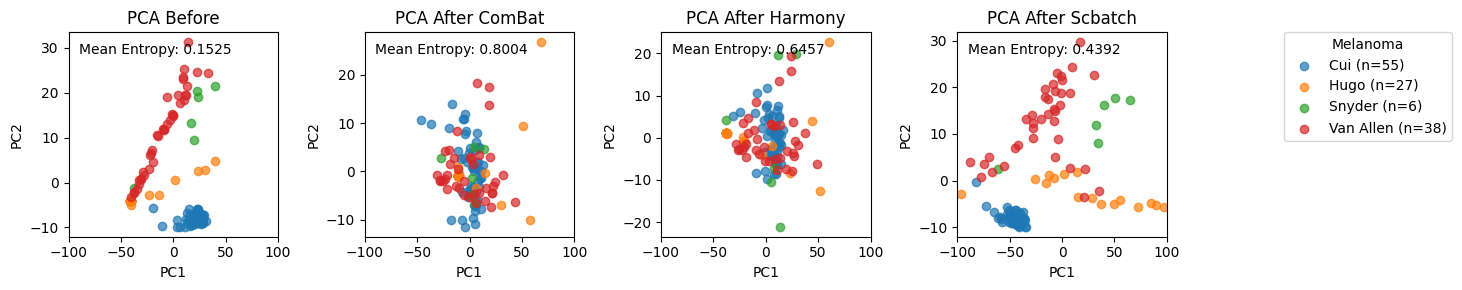

In [1644]:
melanoma_gene_scbatch = pd.read_csv("batchcorrection/scbatch/melanoma_scbatchcorrected.csv", index_col = 0)

#melanoma_gene = pd.concat([melanoma_pd1_gene, melanoma_ctla4_gene], axis = 1, join = "inner")
melanoma_gene = pd.concat([melanoma_pd1_gene, melanoma_ctla4_gene], axis = 1, join = "outer")
melanoma_gene = melanoma_gene.fillna(1e-10)
melanoma_labels = melanoma_pd1_labels + melanoma_ctla4_labels
melanoma_gene_combat = batch_correction(melanoma_gene, melanoma_labels)
melanoma_gene_harmony = batch_correction(melanoma_gene, melanoma_labels, method = "harmony")
batch_effect_comparison(melanoma_gene, melanoma_gene_combat, melanoma_gene_harmony, melanoma_gene_scbatch,
                        melanoma_labels, name = "Melanoma")
melanoma_gene_corrected1 = map_index_id(melanoma_gene_combat, symbol2id1, id2symbol = True)
melanoma_gene_corrected1 = melanoma_gene_corrected1.loc[~melanoma_gene_corrected1.index.duplicated(keep='first')]

##### ccRCC metastatic (bad merging)

In [ ]:
##ccrcc_met_gene.to_csv("batchcorrection/ccrcc_met_gene.csv")
# ccrcc_gene_met_scbatch = pd.read_csv("batchcorrection/scbatch/ccrcc_metgene_scbatchcorrected.csv", index_col = 0)

# ccrcc_met_gene = pd.concat([braun_gene_met_norm, miao_gene_norm], axis = 1, join = "inner")

# n_braun_met = braun_gene_met_norm.shape[1]
# n_miao = miao_gene_norm.shape[1]
# ccrcc_met_labels = [f'Braun Met (n = {n_braun_met})']*n_braun_met + [f'Miao (n = {n_miao})']*n_miao
# ccrcc_met_gene_combat = batch_correction(ccrcc_met_gene, ccrcc_met_labels)
# ccrcc_met_gene_harmony = batch_correction(ccrcc_met_gene, ccrcc_met_labels, method = "harmony")
# batch_effect_comparison(ccrcc_met_gene, ccrcc_met_gene_combat, ccrcc_met_gene_harmony, ccrcc_gene_met_scbatch,
#                         ccrcc_met_labels, name = "Metastatic ccRCC")

##### Braun gene

2025-05-21 13:00:16,243 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-21 13:00:16,608 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-21 13:00:16,610 - harmonypy - INFO - Iteration 1 of 10
2025-05-21 13:00:16,713 - harmonypy - INFO - Iteration 2 of 10
2025-05-21 13:00:16,801 - harmonypy - INFO - Iteration 3 of 10
2025-05-21 13:00:16,886 - harmonypy - INFO - Converged after 3 iterations


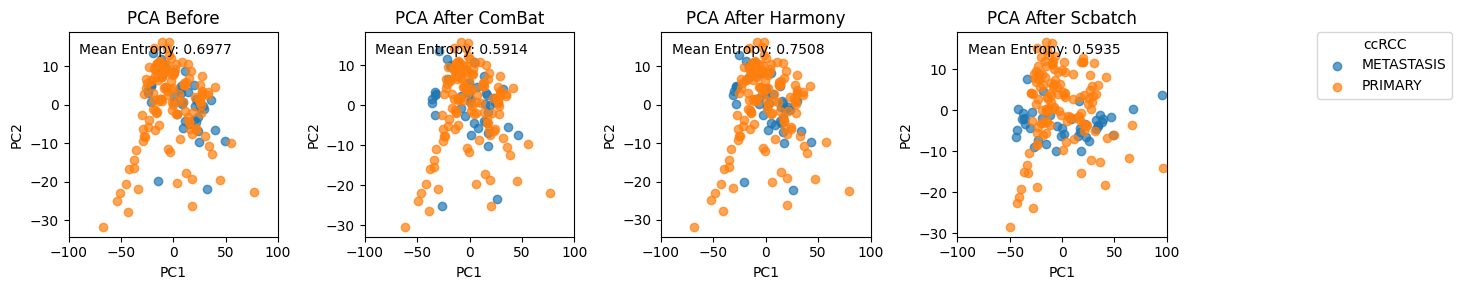

In [1044]:
# braun_gene_norm.to_csv("batchcorrection/braun_gene.csv")
# braun_clin1['Tumor_Sample_Primary_or_Metastasis'].to_csv("batchcorrection/braun_batch.csv")
braun_gene_scbatch = pd.read_csv("batchcorrection/scbatch/braun_scbatchcorrected.csv", index_col = 0)
ccrcc_labels = braun_clin1['Tumor_Sample_Primary_or_Metastasis']
ccrcc_labels = ccrcc_labels[~ccrcc_labels.isna()]
ccrcc_labels = ccrcc_labels[ccrcc_labels!=""]
braun_gene_norm = braun_gene_norm[ccrcc_labels.index]
ccrcc_gene_combat = batch_correction(braun_gene_norm, ccrcc_labels)
ccrcc_gene_harmony = batch_correction(braun_gene_norm, ccrcc_labels, method = "harmony", batch_name = "Tumor_Sample_Primary_or_Metastasis")
batch_effect_comparison(braun_gene_norm, ccrcc_gene_combat, ccrcc_gene_harmony, braun_gene_scbatch,
                        ccrcc_labels, name = "ccRCC")
ccrcc_gene_corrected1 = map_index_id(ccrcc_gene_harmony, symbol2id1, id2symbol = True)
ccrcc_gene_corrected1 = ccrcc_gene_corrected1.loc[~ccrcc_gene_corrected1.index.duplicated(keep='first')]

##### unc 108

2025-05-21 13:27:06,730 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-21 13:27:06,813 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-21 13:27:06,815 - harmonypy - INFO - Iteration 1 of 10
2025-05-21 13:27:06,834 - harmonypy - INFO - Iteration 2 of 10
2025-05-21 13:27:06,853 - harmonypy - INFO - Iteration 3 of 10
2025-05-21 13:27:06,872 - harmonypy - INFO - Converged after 3 iterations


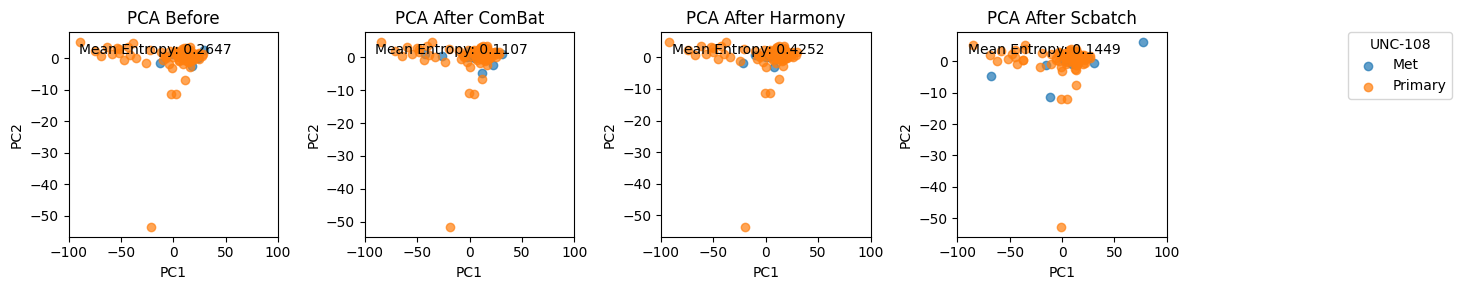

In [1078]:
#dam_gene_norm.to_csv("batchcorrection/dam_gene_norm.csv")
unc108_gene_scbatch = pd.read_csv("batchcorrection/scbatch/unc108_scbatchcorrected.csv", index_col = 0)

unc108_labels = dam_clin1['PRIMARY_MET']
unc108_gene_combat = batch_correction(dam_gene_norm, unc108_labels)
unc108_gene_harmony = batch_correction(dam_gene_norm, unc108_labels, method = "harmony", batch_name = "PRIMARY_MET")
batch_effect_comparison(dam_gene_norm, unc108_gene_combat, unc108_gene_harmony, unc108_gene_scbatch,
                        unc108_labels, name = "UNC-108")
unc108_gene_corrected1 = map_index_id(unc108_gene_harmony, symbol2id1, id2symbol = True)
unc108_gene_corrected1 = unc108_gene_corrected1.loc[~unc108_gene_corrected1.index.duplicated(keep='first')]

##### combined immunotherapy cohort (COM-ICI)

2025-05-22 13:19:31,480 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-22 13:19:33,252 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-22 13:19:33,265 - harmonypy - INFO - Iteration 1 of 10
2025-05-22 13:19:33,709 - harmonypy - INFO - Iteration 2 of 10
2025-05-22 13:19:34,042 - harmonypy - INFO - Iteration 3 of 10
2025-05-22 13:19:34,420 - harmonypy - INFO - Iteration 4 of 10
2025-05-22 13:19:34,712 - harmonypy - INFO - Converged after 4 iterations


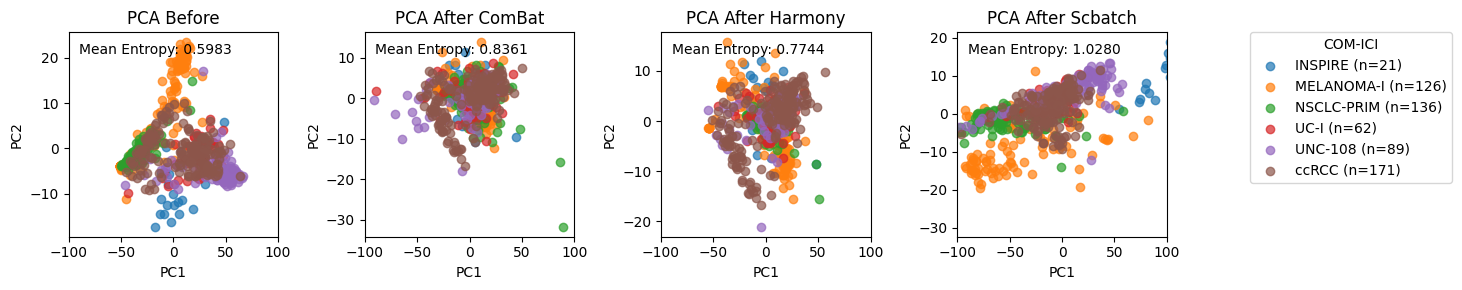

In [1786]:
#combined_gene.to_csv("batchcorrection/combined_gene.csv")
combined_gene_scbatch = pd.read_csv("batchcorrection/scbatch/combined_gene_scbatchcorrected.csv", index_col = 0)

# combined_gene = pd.concat([melanoma_pd1_gene, melanoma_ctla4_gene, ccrcc_gene_harmony, rose_gene_norm, 
#                            unc108_gene_harmony, yang_gene_norm, ravi_gene_norm], axis = 1, join = "inner")
combined_gene = pd.concat([melanoma_pd1_gene, melanoma_ctla4_gene, ccrcc_gene_harmony, rose_gene_norm, 
                           unc108_gene_harmony, yang_gene_norm, ravi_gene_norm], axis = 1, join = "outer")
combined_gene = combined_gene.fillna(1e-10)
combined_gene = remove_empty_row(combined_gene, empty_rate = 1/5)
n_braun = ccrcc_gene_harmony.shape[1]
n_dam = unc108_gene_harmony.shape[1]
n_yang = yang_gene_norm.shape[1]
n_ravi = ravi_gene_norm.shape[1]
n_rose = rose_gene_norm.shape[1]
n_melanoma = melanoma_gene_corrected1.shape[1]
combined_added_labels = [f'UC-I (n={n_rose})']*n_rose + [f'ccRCC (n={n_braun})']*n_braun + [f'UNC-108 (n={n_dam})']*n_dam + [f'INSPIRE (n={n_yang})']*n_yang + [f'NSCLC-PRIM (n={n_ravi})']*n_ravi
combined_labels = [f'MELANOMA-I (n={n_melanoma})']*n_melanoma + combined_added_labels

combined_gene_combat = batch_correction(combined_gene, combined_labels)
combined_gene_harmony = batch_correction(combined_gene, combined_labels, method = "harmony")
batch_effect_comparison(combined_gene, combined_gene_combat, combined_gene_harmony, combined_gene_scbatch, 
                        combined_labels, name = "COM-ICI")
combined_gene_corrected1 = map_index_id(combined_gene_combat, symbol2id1, id2symbol = True)
combined_gene_corrected1 = combined_gene_corrected1.loc[~combined_gene_corrected1.index.duplicated(keep='first')]

##### combined TCGA: COM-TCGA

In [1495]:
# #### map sample to patient
# tcga_cancer = ['BLCA', 'BRCA', 'COAD', 'COADREAD', 'HNSC', 'KIRC', 'LUAD', 'LUSC', 'OV', 'SKCM']
# #tcga_clin = {}
# gene_col_names = []
# patient_barcode = []
# sample_barcode = []
# gender = []
# age = []
# tumor_type = []
# for cancer in tcga_cancer:
#     path = f"/Users/qiluzhou/Desktop/umass/research/immune_score_review/review/data/TCGA/{cancer}/{cancer}.clin.merged.txt"
#     tcga_clin_data = pd.read_table(path, sep = "\t", index_col=0, header = None)
#     #tcga_clin[cancer] = tcga_clin_data
#     print(cancer)
#     gene_col_names.extend(tcga_clin_data.loc['patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot.bcr_aliquot_barcode'])
#     patient_barcode.extend(tcga_clin_data.loc['patient.bcr_patient_barcode'])
#     sample_barcode.extend(tcga_clin_data.loc['patient.samples.sample.bcr_sample_barcode'])
#     age.extend(tcga_clin_data.loc['patient.age_at_initial_pathologic_diagnosis'])
#     gender.extend(tcga_clin_data.loc['patient.gender'])
#     tumor_type.extend(tcga_clin_data.loc['patient.stage_event.tnm_categories.pathologic_categories.pathologic_m'])
# tcga_idmatch = pd.DataFrame({'sample_barcode': [s.replace("-", ".") for s in sample_barcode], 
#                              'patient_barcode': map(str.upper, patient_barcode), 
#                              'gene_col_names': gene_col_names,
#                              'age': map(float, age),
#                              'gender': gender,
#                              'tumor_type': tumor_type})
# tcga_idmatch = tcga_idmatch.dropna(subset = ["gender", "age", 'tumor_type'])
# tcga_idmatch = tcga_idmatch[tcga_idmatch['tumor_type']!="mx"]
#tcga_idmatch['tumor_status'] = tcga_idmatch['tumor_type'].apply(lambda x: "primary" if "m0" in x else "met")


tcga_dfs = pd.read_csv("/Users/qiluzhou/Desktop/umass/research/immune_score_review/review/data/pancancer/DFS_data.csv", 
                       index_col = 'gene_col_names')
tcga_os = pd.read_table("/Users/qiluzhou/Desktop/umass/research/immune_score_review/review/data/pancancer/survival.txt", 
              sep = ",", index_col = "gene_col_names")
tcga_genes = pd.read_table("/Users/qiluzhou/Desktop/umass/research/immune_score_review/review/data/pancancer/tcga_gene_raw.txt", 
                           sep = "\t", index_col=0) 
tcga_genes = remove_empty_row(tcga_genes)
tcga_os.index = tcga_os.index.map(lambda x: x.upper() if isinstance(x, str) else x)
tcga_dfs.index = tcga_dfs.index.map(lambda x: x.upper() if isinstance(x, str) else x)
tcga_os1 = tcga_os.dropna(subset = ['vital', 'time'])
tcga_dfs1 = tcga_dfs.dropna(subset = ['DFS_STATUS', 'DFS_MONTHS'])
tcga_norm_os, tcga_os_clin = data_prep(tcga_genes, tcga_os1) ## 1127 samples
tcga_norm_dfs, tcga_dfs_clin = data_prep(tcga_genes, tcga_dfs1) ## 1232 samples
tcga_os_clin = tcga_os_clin.loc[~tcga_os_clin.index.duplicated(keep='first')]
tcga_dfs_clin = tcga_dfs_clin.loc[~tcga_dfs_clin.index.duplicated(keep='first')]
tcga_norm_os = tcga_norm_os.fillna(1e-10)
tcga_norm_dfs = tcga_norm_dfs.fillna(1e-10)
tcga_os_clin['os_months'] = tcga_os_clin['time']
tcga_os_clin['os_event'] = tcga_os_clin['vital'].apply(lambda x: 1 if x == "dead" else 0)  
tcga_dfs_clin['DFS_event'] = tcga_dfs_clin['DFS_STATUS'].apply(lambda x: 1 if x == '1:Recurred/Progressed' else 0)      

2025-05-22 09:44:00,375 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-22 09:44:02,730 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-22 09:44:02,737 - harmonypy - INFO - Iteration 1 of 10
2025-05-22 09:44:03,396 - harmonypy - INFO - Iteration 2 of 10
2025-05-22 09:44:04,033 - harmonypy - INFO - Iteration 3 of 10
2025-05-22 09:44:04,654 - harmonypy - INFO - Iteration 4 of 10
2025-05-22 09:44:05,166 - harmonypy - INFO - Converged after 4 iterations


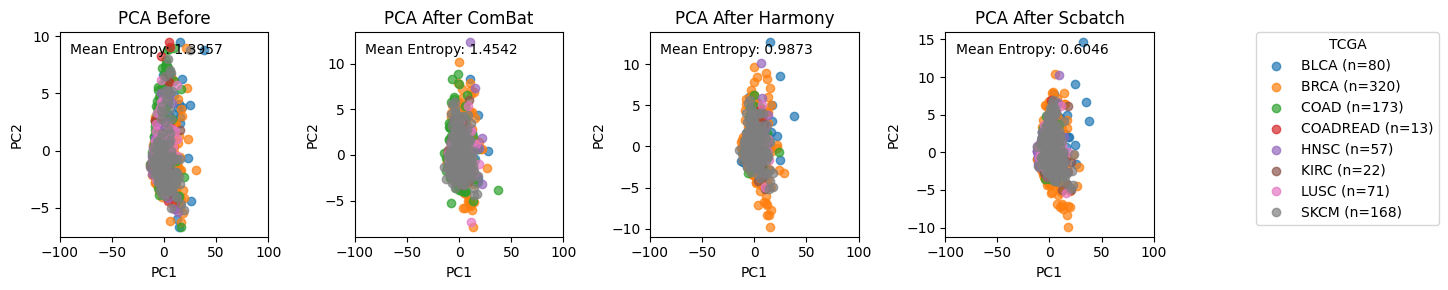

In [1553]:
## batch correction
tcga_os_scbatch = pd.read_csv("batchcorrection/scbatch/tcga_os_scbatchcorrected.csv", index_col = 0)
os_sample = list(set(tcga_os_scbatch.columns) & set(tcga_norm_os.columns))
cancer_map = tcga_os_clin['cancer'].value_counts().index + " (n=" + tcga_os_clin['cancer'].value_counts().astype(str) + ")"
cancer_key = tcga_os_clin['cancer'].value_counts().index
tcga_os_clin = tcga_os_clin.loc[os_sample]
tcga_os_clin['batch'] = tcga_os_clin['cancer'].apply(lambda x: cancer_map[cancer_key.get_loc(x)])
tcga_os_combat = batch_correction(tcga_norm_os[os_sample], tcga_os_clin['batch'])
tcga_os_harmony = batch_correction(tcga_norm_os[os_sample], tcga_os_clin['batch'], method = "harmony", batch_name='batch')
tcga_os_combat1 = tcga_os_combat.fillna(1e-10)
tcga_os_harmony1 = tcga_os_harmony.fillna(1e-10)
tcga_os_scbatch1 = tcga_os_scbatch[os_sample]
batch_effect_comparison(tcga_norm_os, tcga_os_combat1, tcga_os_harmony1, tcga_os_scbatch1,
                        tcga_os_clin['batch'], name = "TCGA")
tcga_os_corrected = tcga_os_combat1

In [1061]:
## batch correction

# tcga_dfs_combat = batch_correction(tcga_norm_dfs, tcga_dfs_clin['Study.ID'])
# tcga_dfs_harmony = batch_correction(tcga_norm_dfs, tcga_dfs_clin['Study.ID'], method = "harmony", batch_name='Study.ID')
# tcga_dfs_combat1 = tcga_dfs_combat.fillna(1e-10)
# tcga_dfs_harmony1 = tcga_dfs_harmony.fillna(1e-10)
# batch_effect_comparison(tcga_norm_dfs, tcga_dfs_combat1, tcga_dfs_harmony1, tcga_dfs_harmony1,
#                         tcga_dfs_clin['Study.ID'], name = "COM-TCGA-II")
# tcga_dfs_corrected = tcga_dfs_combat1

### all biomarkers

In [1571]:
## geometric mean

CYT1 = ['GZMA', 'PRF1']
CYT2 = ['B2M', 'HLA-A', 'HLA-B', 'HLA-C', 'CASP8']
EXH = ['PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'TIGIT']
IFNr = ['IDO1', 'CXCL10', 'CXCL9', 'HLA-DRA', 'STAT1', 'IFNG']
TLS = ['BCL6', 'CD86', 'CXCR4', 'LAMP3', 'SELL', 'CCR7', 'CXCL13', 'CCL21', 'CCL19']

## average mean
TIP_hot = ['CXCL9', 'CXCL10', 'CXCL11', 'CXCR3', 'CD3','CD4','CD8A','CD8B', 'CD274', 'PDCD1', 'CXCE4', 'CCL5']
TIP_cold = ['CXCL1','CXCL2', 'CCL20']

## ratio
CS_polarity = ['SPP1', 'CXCL9']

## IMPRES
IMPRES = {'Gene1': ['PDCD1','CD27', 'CTLA4', 'CD40', 'CD86', 'CD28', 'CD80', 'CD274', 'CD86', 'CD40', 'CD86', 
                'CD40', 'CD28', 'CD40', 'TNFRSF14'],
            'Gene2': ['TNFSF4', 'PDCD1', 'TNFSF4', 'CD28', 'TNFSF4', 'CD86', 'TNFSF9', 'VSIR', 'HAVCR2', 'PDCD1',
                      'CD200', 'CD80', 'CD276', 'CD274', 'CD86']}

## ssGSEA
TGFb = {'TGFb':['SLC20A1', 'XIAP', 'TGFBR1', 'BMPR2','FKBP1A', 'SKIL']}

def get_all_score(df, clin, cancer = "Other", response_col = "CB"):
    if not all(isinstance(idx, str) for idx in df.index):
        df = map_index_id(df, symbol2id1, id2symbol = True)
        df = df.loc[~df.index.duplicated(keep='first')]
    cyt1_score = get_geomean_score(df, CYT1, "CYT1")
    cyt2_score = get_geomean_score(df, CYT2, "CYT2")
    exh_score = get_geomean_score(df, EXH, "EXH")
    ifnr_score = get_geomean_score(df, IFNr, "IFNr")
    tls_score = get_geomean_score(df, TLS, "TLS")
    tip_hotscore = get_avgmean_score(df, TIP_hot, "TIP Hot")
    tip_coldscore = get_avgmean_score(df, TIP_cold, "TIP Cold")
    cs_polarity_score = get_ratio_score(df, CS_polarity, "CS Polarity")
    impres_score = get_impres_score(df, IMPRES, "IMPRES")
    tgfb_score = get_ssgsea_score(df, TGFb)
    score_df = pd.concat([cyt1_score, cyt2_score, exh_score, ifnr_score, tls_score, 
                          tip_hotscore, tip_coldscore, cs_polarity_score, impres_score, tgfb_score], axis = 1)
    score_df.columns = ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb']
    ## the other scores in tmeimmune
    tmeimmune_score = TME_score.get_score(df, method = ['ISTME', 'NetBio', 'SIA'], clin = clin, test_clinid = response_col)
    df_log2 = np.log2(df + 1)
    row_means = df_log2.mean(axis=1)
    df_centered = df_log2.sub(row_means, axis=0)
    tide_score = TIDE(df_centered, cancer, pretreat = True, vthres = 0.)['TIDE']
    score_df = pd.concat([score_df, tmeimmune_score, tide_score], axis = 1)
    return score_df

### Get all scores

In [ ]:
# kassandra_output = pd.read_csv("kassandra_deconv/kassandra_output_all.csv", index_col = 0)
# B_cell_score = kassandra_output.T['B_cells']
# CDTreg = kassandra_output.T['CD8_T_cells']/ kassandra_output.T['Tregs']

full_clin = pd.read_csv("full_clinical_data.csv", index_col=0)
# combined_score = get_all_score(combined_gene_corrected1, full_clin)
#combined_score = pd.concat([combined_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# combined_score = combined_score.rename(columns = {0: "CD8Treg"})
# combined_score.to_csv("all_score_combined.csv")
combined_score = pd.read_csv("all_score_combined.csv", index_col = 0)
combined_score = remove_outlier(combined_score)
scaler = MinMaxScaler(feature_range=(0,1))
combined_score = scaler.fit_transform(combined_score)
# melanoma_score = get_all_score(melanoma_gene_corrected1, full_clin)
# melanoma_score = pd.concat([melanoma_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# melanoma_score = melanoma_score.rename(columns = {0: "CD8Treg"})
# melanoma_score.to_csv("all_score_melanoma.csv")
melanoma_score = pd.read_csv("all_score_melanoma.csv", index_col = 0)
melanoma_score = remove_outlier(melanoma_score)
#melanoma_score = remove_outlier(melanoma_score, identical = True)
melanoma_score = scaler.fit_transform(melanoma_score)
# ccrcc_score = get_all_score(ccrcc_gene_corrected1, full_clin)
# ccrcc_score = pd.concat([ccrcc_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# ccrcc_score = ccrcc_score.rename(columns = {0: "CD8Treg"})
# ccrcc_score.to_csv("all_score_ccrcc.csv")
ccrcc_score = pd.read_csv("all_score_ccrcc.csv", index_col = 0)
ccrcc_score = remove_outlier(ccrcc_score)
ccrcc_score = scaler.fit_transform(ccrcc_score)
# urothelial_met_score = get_all_score(rose_gene_norm, full_clin)
# urothelial_met_score = pd.concat([urothelial_met_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# urothelial_met_score = urothelial_met_score.rename(columns = {0: "CD8Treg"})
# urothelial_met_score.to_csv("all_score_urothelial_met.csv")
urothelial_met_score = pd.read_csv("all_score_urothelial_met.csv", index_col=0)
urothelial_met_score = remove_outlier(urothelial_met_score)
urothelial_met_score = scaler.fit_transform(urothelial_met_score)
# unc108_score = get_all_score(unc108_gene_corrected1, full_clin)
# unc108_score = pd.concat([unc108_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# unc108_score = unc108_score.rename(columns = {0: "CD8Treg"})
# unc108_score.to_csv("all_score_unc108.csv")
unc108_score = pd.read_csv("all_score_unc108.csv", index_col = 0)
unc108_score = remove_outlier(unc108_score)
unc108_score = scaler.fit_transform(unc108_score)

## single dataset: not in any merge dataset
# vath_score = get_all_score(vath_gene_norm, vath_clin1, response_col="clinical_benefit")
# vath_score = pd.concat([vath_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# vath_score = vath_score.rename(columns = {0: "CD8Treg"})
# vath_score.to_csv("all_score_vathiotis.csv")
vath_score = pd.read_csv("all_score_vathiotis.csv", index_col=0)
vath_score = remove_outlier(vath_score)
vath_score = scaler.fit_transform(vath_score)
# foy_nsclc_score = get_all_score(foy_nsclc_gene_norm1, foy_nsclc_clin1, response_col="clinical_benefit")
# foy_nsclc_score = pd.concat([foy_nsclc_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# foy_nsclc_score = foy_nsclc_score.rename(columns = {0: "CD8Treg"})
# foy_nsclc_score.to_csv("all_score_foy_nsclc.csv")
foy_nsclc_score = pd.read_csv("all_score_foy_nsclc.csv", index_col=0)
foy_nsclc_score = remove_outlier(foy_nsclc_score)
foy_nsclc_score = scaler.fit_transform(foy_nsclc_score)
# foy_hnscc_score = get_all_score(foy_hnscc_gene_norm, foy_hnscc_clin1, response_col="clinical_benefit")
# foy_hnscc_score = pd.concat([foy_hnscc_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# foy_hnscc_score = foy_hnscc_score.rename(columns = {0: "CD8Treg"})
# foy_hnscc_score.to_csv("all_score_foy_hnscc.csv")
foy_hnscc_score = pd.read_csv("all_score_foy_hnscc.csv", index_col=0)
foy_hnscc_score = remove_outlier(foy_hnscc_score)
foy_hnscc_score = scaler.fit_transform(foy_hnscc_score)
# ravi_score = get_all_score(ravi_gene_norm1, ravi_clin2)
# ravi_score = pd.concat([ravi_score, B_cell_score, CDTreg], axis = 1, join = "inner")
# ravi_score = ravi_score.rename(columns = {0: "CD8Treg"})
# ravi_score.to_csv("all_score_ravi.csv")
ravi_score = pd.read_csv("all_score_ravi.csv", index_col = 0)
ravi_score = remove_outlier(ravi_score)
ravi_score = scaler.fit_transform(ravi_score)
#tcga_os_score = pd.concat([tcga_os_score, B_cell_score, CDTreg], axis = 1, join = "inner")
tcga_os_score = pd.read_csv("all_score_tcga_os.csv", index_col = 0)
tcga_os_score = remove_outlier(tcga_os_score)
tcga_os_score = scaler.fit_transform(tcga_os_score)
#tcga_dfs_score = pd.concat([tcga_dfs_score, B_cell_score, CDTreg], axis = 1, join = "inner")
#tcga_dfs_score = pd.read_csv("all_score_tcga_dfs.csv", index_col = 0)

In [1861]:
###  merged dataset
score_cols = ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
                'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg']

def divide_group(df, score_list = score_cols, half = False):
    for score in score_list:
        score_group = score + "_group"
        if half:
            q_m = df[score].median()
            df[score_group] = "L"
            df.loc[df[score] > q_m, score_group] = "H"

        else:
            q_low, q_high = df[score].quantile([0.25, 0.75])
            df[score_group] = 'M'
            df.loc[df[score] <= q_low, score_group] = 'L'
            df.loc[df[score] >= q_high, score_group] = 'H'
    return df

combined_data = combined_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
melanoma_data = melanoma_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
combined_data1 = divide_group(combined_data)
melanoma_data1 = divide_group(melanoma_data)

vath_data = vath_score.merge(vath_clin, left_index = True, right_index = True, how = "inner")
ccrcc_data = ccrcc_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
unc108_data = unc108_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
urothelial_met_data = urothelial_met_score.merge(full_clin, left_index = True, right_index = True, how = "inner")
foy_nsclc_data = foy_nsclc_score.merge(foy_nsclc_clin, left_index = True, right_index = True, how = "inner")
ravi_data = ravi_score.merge(ravi_clin2, left_index = True, right_index = True, how = "inner")
foy_hnscc_data = foy_hnscc_score.merge(foy_hnscc_clin, left_index = True, right_index = True, how = "inner")

vath_data1 = divide_group(vath_data)
ccrcc_data1 = divide_group(ccrcc_data)
unc108_data1 = divide_group(unc108_data)
urothelial_met_data1 = divide_group(urothelial_met_data)
foy_nsclc_data1 = divide_group(foy_nsclc_data)
ravi_data1 = divide_group(ravi_data)
foy_hnscc_data1 = divide_group(foy_hnscc_data)


##### Cox PH: survival = score + dataset_id + tumor type + gender + age + treatment

In [1862]:
## merged dataset
cox_combined, cindex_combined, cindex_combined_var = fit_coxph(combined_data1, 
                                                               name = "COM-ICI", merge_type="cancer") # use model[score].summary to get the coef
cox_melanoma, cindex_melanoma, cindex_melanoma_var = fit_coxph(melanoma_data1, 
                                                               name = "MELANOMA-I", merge_type="treatment")

tcga_os_data = tcga_os_score.merge(tcga_os_clin, left_index = True, right_index = True, how = "inner")
tcga_os_data1 = divide_group(tcga_os_data)
cox_tcga_os, cindex_tcga_os, cindex_tcga_os_var = fit_coxph(tcga_os_data1,
                                                            name = "TCGA", 
                                                            merge_type="tumor_type", tcga = True, tcga_source = "cancer")

# cox_tcga_dfs, cindex_tcga_dfs, cindex_tcga_dfs_var = fit_coxph(tcga_dfs_score, tcga_dfs_clin, event = 'DFS_event', time = 'DFS_MONTHS',
#                                                             name = "COM-TCGA-II", 
#                                                             merge_type="tumor_type", tcga = True, tcga_source = "Study.ID")

COM-ICI : ['EXH'] have the highest c-index in coxph, the best c-index = 0.6651, variance = 0.0000
MELANOMA-I : {'cancer', 'tumor_type'} are dropped because they only have one level
MELANOMA-I : ['IFNr'] have the highest c-index in coxph, the best c-index = 0.7317, variance = 0.0006
TCGA : ['IFNr'] have the highest c-index in coxph, the best c-index = 0.7620, variance = 0.0002


#### univariate coxph

In [1863]:
cox_combined_uni, cindex_combined_uni, cindex_combined_uni_var = fit_coxph(combined_data1, name = "COM-ICI") 
cox_melanoma_uni, cindex_melanoma_uni, cindex_melanoma_uni_var = fit_coxph(melanoma_data1, name = "MELANOMA-I")
cox_tcga_os_uni, cindex_tcga_os_uni, cindex_tcga_os_var_uni = fit_coxph(tcga_os_data1, name = "COM-TCGA-I", tcga = True, tcga_source = "cancer")

# cox_tcga_dfs_uni, cindex_tcga_dfs_uni, cindex_tcga_dfs_var_uni = fit_coxph(tcga_dfs_score, tcga_dfs_clin, event = 'DFS_event', 
#                                                                            time = 'DFS_MONTHS',
#                                                             name = "COM-TCGA-II", tcga = True, tcga_source = "Study.ID")

COM-ICI : ['EXH'] have the highest c-index in coxph, the best c-index = 0.6200, variance = 0.0014
MELANOMA-I : {'cancer', 'tumor_type'} are dropped because they only have one level
MELANOMA-I : ['CS Polarity'] have the highest c-index in coxph, the best c-index = 0.6310, variance = 0.0018
COM-TCGA-I : ['TIP Hot'] have the highest c-index in coxph, the best c-index = 0.5819, variance = 0.0011


In [ ]:
cox_combined_multi = extract_cox_summary(cox_combined, cindex_combined)
cox_combined_uni1 = extract_cox_summary(cox_combined_uni, cindex_combined_uni, form = "univariate")
cox_combined_df = pd.concat([cox_combined_multi, cox_combined_uni1], axis = 0)

cox_melanoma_multi = extract_cox_summary(cox_melanoma, cindex_melanoma)
cox_melanoma_uni1 = extract_cox_summary(cox_melanoma_uni, cindex_melanoma_uni, form = "univariate")
cox_melanoma_df = pd.concat([cox_melanoma_multi, cox_melanoma_uni1], axis = 0)

cox_tcga_os_multi = extract_cox_summary(cox_tcga_os, cindex_tcga_os)
cox_tcga_os_uni1 = extract_cox_summary(cox_tcga_os_uni, cindex_tcga_os_uni, form = "univariate")
cox_tcga_os_df = pd.concat([cox_tcga_os_multi, cox_tcga_os_uni1], axis = 0)

# with pd.ExcelWriter("coxph_output.xlsx", engine="openpyxl") as writer:
#     cox_combined_df.to_excel(writer, sheet_name="COM-ICI", index=True)
#     cox_melanoma_df.to_excel(writer, sheet_name="MELANOMA-I", index=True)
#     cox_tcga_os_df.to_excel(writer, sheet_name="COM-TCGA-I", index=True)

##### forest plot of coxph results

In [1865]:
def HR_forest(ax, ax_table, cox_df, title, palette = ["#9DAEB6",  "#3D5C6F"]):

    mask = cox_df.index.get_level_values(0) == cox_df.index.get_level_values(1)
    hr_df = cox_df[mask].copy()

    hr_df = hr_df.rename(columns={
        'exp(coef)':           'HR',
        'exp(coef) lower 95%': 'lower95',
        'exp(coef) upper 95%': 'upper95',
    })

    # sig_scores = (hr_df.groupby(hr_df.index)['p']
    #   .apply(lambda ps: (ps < 0.05).any())
    #   .loc[lambda s: s]
    #   .index
    #   .tolist())
    #hr_df1 = hr_df[hr_df.index.isin(sig_scores)].copy()

    hr_df1 = hr_df.sort_values(by = 'HR', ascending=True)
    ci_wide = hr_df1.pivot(index='score', columns='regression', values='c-index')
    scores  = list(i[0] for i in hr_df1.index.unique().tolist())
    y_base  = np.arange(len(scores))
    y_map   = dict(zip(scores, y_base))

    # small vertical offsets so U/M points don’t sit on top of each other
    offsets = {'univariate': +0.10, 'multivariate': -0.10}

    # 2) Set up figure with two columns, shared y-axis
    # fig = plt.figure(figsize=(6, len(scores)*0.6 + 1))
    # gs  = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.05)

    # ax      = fig.add_subplot(gs[0, 0])        # forest plot
    # ax_table = fig.add_subplot(gs[0, 1], sharey=ax)  # c-index “table”

    # 3) Draw the forest
    for model, grp in hr_df1.groupby('regression'):
        y_vals   = [y_map[s] + offsets[model] for s in grp['score']]
        hr       = grp['HR']
        lo_err   = hr - grp['lower95']
        hi_err   = grp['upper95'] - hr

        ax.errorbar(
            hr, y_vals,
            xerr=[lo_err, hi_err],
            fmt='o',
            c = palette[0] if model == 'univariate' else palette[1],
            label=model.capitalize(),
            capsize=3
        )

    ax.axvline(1, color='lightgray', linestyle='--', lw=1)
    ax.set_yticks(y_base)
    ax.set_yticklabels(scores, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    #ax.set_xlim(-0.5, 2.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_xlabel("Log (HR) (95% CI)", fontsize=12, fontweight='bold')
    ax.legend(frameon=False, title="", loc = "lower right", fontsize=10, prop={'weight':'bold'},bbox_to_anchor=(1.15, 0.95))

    #ax_table.xaxis.set_visible(True)
    ax_table.xaxis.tick_top()                 # move ticks & labels to top
    ax_table.tick_params(axis="x", length=0)  # no little tick-marks

    # 3) Set your two column headers
    ax_table.set_xticks([0, 1])
    ax_table.set_xticklabels(
        ["Uni", "Multi"],
        ha="center",
        va="bottom",   # or "top" if you want the text sitting above the tick line
        fontsize=12, fontweight='bold'
    )
    # ax_table.text(0, len(scores)-0.5, "Uni C-index", ha='center', va='top')
    # ax_table.text(1, len(scores)-0.5, "Multi C-index", ha='center', va='top')

    for score, y in y_map.items():
        uni   = ci_wide.loc[score,'univariate']
        multi = ci_wide.loc[score,'multivariate']
        ax_table.text(0, y, f"{uni:.4f}",   ha='center', va='center', fontsize=10, fontweight='bold')
        ax_table.text(1, y, f"{multi:.4f}", ha='center', va='center', fontsize=10, fontweight='bold')

    ax_table.set_xlim(-0.5, 1.5)
    ax_table.set_title("C-index", fontsize=12, fontweight='bold')

    for loc in ['top','right']:
        ax.spines[loc].set_visible(False)

    # table: drop all spines
    for spine in ax_table.spines.values():
        spine.set_visible(False)
    ax_table.set_facecolor('none')
    ax_table.patch.set_visible(False)

    return ax, ax_table


#### barplot of auc

In [1866]:


def auc_plot(ax, df, name, resp_col = "resp", score_cols = score_cols, show_sig = True, palette = "#1f77b4"):
    aucs = {}
    for col in score_cols:
        df1 = df.dropna(subset = col)
        df1 = df1[np.isfinite(df1[col])]
        aucs[col] = roc_auc_score(df1[resp_col], df1[col])

    auc_df = pd.DataFrame({"score": list(aucs.keys()), "AUC": list(aucs.values())})
    auc_df_sorted = auc_df.sort_values("AUC", ascending=False).reset_index(drop=True)

    if show_sig:
        auc_df_sorted = auc_df_sorted[auc_df_sorted["AUC"] > 0.5]
        ax.bar(auc_df_sorted["score"], auc_df_sorted["AUC"], color = palette)
        ax.set_ylim(0.5,0.8)   
        ax.grid(True, alpha = 0.3)
    else:
        ax.bar(auc_df_sorted["score"], auc_df_sorted["AUC"], color = palette)
        ax.axhline(0.5, color="darkgray", linestyle="--", label="AUC = 0.5")
        ax.set_ylim(0,0.8) 
        ax.legend(frameon=False, loc = "upper right", fontsize=10, prop={'weight':'bold'})

    ax.set_xlabel("")
    ax.set_xticklabels(auc_df_sorted["score"], rotation=45, ha="right", fontsize=12, fontweight='bold')
    ax.set_ylabel("AUC", fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')
    ax.set_title(name, fontsize=14, fontweight='bold')
    return ax, aucs, auc_df_sorted['score']


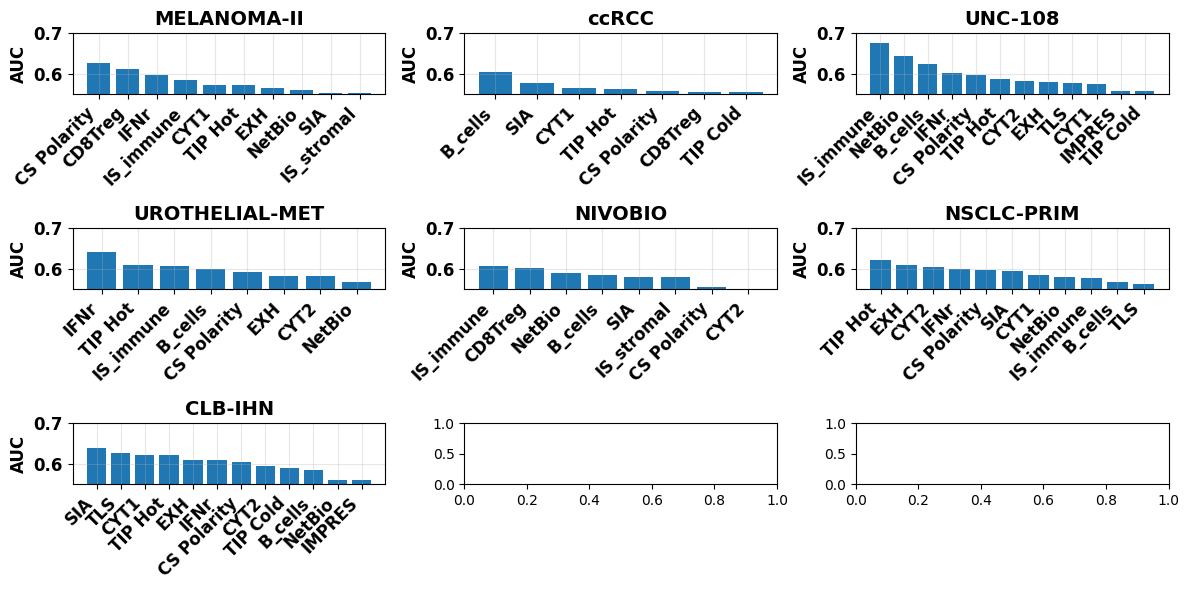

In [1867]:
## melanoma: ['CYT1', 'EXH','IFNr','TIP Hot', 'IS_immune'] > 0.5 in all four data cohorts

fig, axs = plt.subplots(3, 3, figsize=(12, 6))


_, aucs_vath,_ = auc_plot(axs[0,0], vath_data, name = "MELANOMA-II", resp_col = "resp")
_, aucs_ccrcc,_ = auc_plot(axs[0,1], ccrcc_data, name = "ccRCC")
_, aucs_unc108,_ = auc_plot(axs[0,2], unc108_data, name = "UNC-108")
_, aucs_uc_met,_ = auc_plot(axs[1,0], urothelial_met_data, name = "UROTHELIAL-MET")
_, aucs_foy_nsclc,_ = auc_plot(axs[1,1], foy_nsclc_data, name = "NIVOBIO", resp_col="resp")
_, aucs_ravi,_ = auc_plot(axs[1,2], ravi_data, name = "NSCLC-PRIM")
_, aucs_foy_hnscc,_ = auc_plot(axs[2,0], foy_hnscc_data, name = "CLB-IHN", resp_col="resp")

plt.tight_layout()
plt.show()

#### treatment survival: use the combined dataset and the single datasets

In [1868]:
def km_survival(ax, df, time, delta, score_list, ylab, custom_palette = ["#547AC0", "#898988", "#F6C957"], sig = False):#["#3D5C6F", "#9DAEB6"]dark blue: "#6699CC"

    # remove NAs for unknown vital status and survival time
    df1 = df[~df[delta].isna()]
    df1 = df1[~df1[time].isna()]
    kmf_H = KaplanMeierFitter()
    kmf_L = KaplanMeierFitter()

    # if ax is None:
    #     fig,ax = plt.subplots()
    # else:
    #     fig = ax.get_figure()
    n_score = len(score_list)
    ncol = 4
    nrow = (n_score+ncol-1)//ncol
    # fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow), sharey=True)
    # axs = axs.flatten()
    
    # for ax, score in zip(axs, score_list):
    score_col = score_list+"_group"
    # Fit the model for each group
    kmf_H.fit(durations=df1[df1[score_col] == 'H'][time], event_observed=df1[df1[score_col] == 'H'][delta], label='H')
    kmf_L.fit(durations=df1[df1[score_col] == 'L'][time], event_observed=df1[df1[score_col] == 'L'][delta], label='L')

    n_H = df1[df1[score_col] == 'H'].shape[0]
    n_L = df1[df1[score_col] == 'L'].shape[0]
        
    # Plot the survival curves
    kmf_H.plot_survival_function(show_censors = True, color=custom_palette[0], ci_show=False, ax = ax)

    kmf_M = KaplanMeierFitter()
    kmf_M.fit(durations=df1[df1[score_col] == 'M'][time], event_observed=df1[df1[score_col] == 'M'][delta], label='M')
    kmf_M.plot_survival_function(show_censors = True, color=custom_palette[2], ci_show=False, ax = ax)
    
    kmf_L.plot_survival_function(show_censors = True, color=custom_palette[1], ci_show=False, ax = ax)

    # perform log-rank test to the high and low groups
    df1[time] = pd.to_numeric(df1[time], errors='coerce')
    df1[delta] = pd.to_numeric(df1[delta], errors='coerce')
    results = logrank_test(df1[df1[score_col] == 'H'][time], df1[df1[score_col] == 'L'][time], 
                        event_observed_A=df1[df1[score_col] == 'H'][delta], event_observed_B=df1[df1[score_col] == 'L'][delta])

    # Add title and labels
    n = df1.shape[0]
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel(ylab, fontsize = 14, fontweight = 'bold')
    ax.set_ylim(0,1.1)
    xticks = ax.get_xticks()
    xticks_rounded = np.round(xticks, decimals=0)
    ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 14)
    ax.set_yticklabels(["0.0","0.2", "0.4", "0.6", "0.8", "1.0"] ,weight = 'bold', size = 14)

    ax.set_ylabel("")
    if sig:
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 16, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold", color='darkred',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=1.5))
    else:
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 16, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold")
    # ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
    #     fontsize = 16, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold")
    ax.get_legend().remove()

    #ax.set_xlabel("Time(Months)", fontsize = 18, fontweight = "bold")
    ax.set_title(score_list, fontweight = 'bold', fontsize = 18)

        # for ax in axs[n_score:]:
        #     ax.set_visible(False)

    return ax, fig

In [ ]:
#### COM-ICI: only CS Polarity, IMPRES, NetBio, SIA, TGFb, TIP Cold, CD8Treg not significant

# km_survival(combined_data1, "os_months", "os_event", ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                 'NetBio', 'SIA', 'TIDE', 'B_cells'], "COM-ICI")

In [ ]:
#### melanoma significant: only CYT1, CYT2, EXH, IFNr, TIP Hot

# km_survival(melanoma_data1, "os_months", "os_event", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                  'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "MELANOMA-I")

In [ ]:
#### melanoma-II significant: only CS Polarity, IS immune

# vath_data1['os_months'] = vath_data1['os_days']/30
# km_survival(vath_data1, "os_months", "os_status", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                  'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "MELANOMA-II")

In [ ]:
#### ccRCC primary: CYT1, EXH, IFNr, TLS, TIP Hot, TIP Cold, IS immune, CD8Treg

# km_survival(ccrcc_primary_data1, "os_months", "os_event", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                   'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "ccRCC-PRIM")

In [ ]:
#### UC met: CYT1, CYT2, EXH, IFNr, TLS, TIP Hot, CS Polarity, IS immune, NetBio, TIDE, B cells

# km_survival(urothelial_met_data1, "os_months", "os_event", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                    'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "UC-MET")

In [1213]:
#### UC primary: CS Polarity, IMPRES, IS_immune, IS_stromal, NetBio, B cells, CD8Treg

# km_survival(unc108_data1, "os_months", "os_event", 
#             score_list = ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                     'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], ylab = "UNC-108")

In [ ]:
#### foy hnscc: significant CYT1, EXH, IFNr, TLS, TIP hot, CS Polarity, SIA, TIDE, IS immune, IS stromal

# km_survival(foy_hnscc_data1, "OS_month", "OS_status", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                      'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "CLB-IHN")

In [ ]:
#### foy nsclc: significant IS immune, CS Polarity, TGFb, TIDE

# km_survival(foy_nsclc_data1, "OS_month", "OS_event", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                       'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "NIVOBIO")

In [ ]:
#### ravi nsclc: significant CYT1, CYT2, EXH, IFNr, TLS, TIP hot, CS Polarity, IMPRES, IS_immune, TIDE, B_cells

# km_survival(ravi_data1, "os_months", "os_event", 
#             ['CYT1', 'CYT2', 'EXH','IFNr','TLS','TIP Hot','TIP Cold', 'CS Polarity','IMPRES','TGFb', 'IS_immune', 'IS_stromal',
#                        'NetBio', 'SIA', 'TIDE', 'B_cells', 'CD8Treg'], "NSCLC-PRIM")

#### boxplot of responders and non-responders vs. score group

In [1869]:

def mwu_test(df, score_list, resp_col = "resp"):
    results = []
    for score in score_list:
        df1 = df.dropna(subset = score)
        r  = df1.loc[df1[resp_col]==1, score]
        nr = df1.loc[df1[resp_col]==0,score]
        U, p = stats.mannwhitneyu(r, nr, alternative='two-sided')
        rho, _ = spearmanr(df1[score], df1[resp_col])
        results.append({'score':score, 'U_stat':U, 'p_value':p, 'rho': rho})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value').reset_index(drop=True)
    return results_df


def box_resp(ax, df, scores, name, resp_col = "resp", col_palette = {"R": "#8BCBF1", "NR": "#498AC7"}):
    """ 
    Boxplots to compare the distribution of scores in responders vs non-responders
    """
    
    #fig, ax = plt.subplots(figsize = (len(scores)*1.5, 6))
    x = "score"
    y = "value"
    hue = "response"
    hue_order = ["R", "NR"]

    results_df = mwu_test(df, scores, resp_col)
    results_df = results_df.sort_values('p_value').reset_index(drop=True)
    order = results_df['score'].tolist()

    df1 = df.assign(response = df[resp_col].map({1:'R',0:'NR'})).melt(id_vars=['response'], 
            value_vars=scores,
            var_name='score', value_name='value')
    
    sns.boxplot(ax = ax, x=x, y=y, hue = hue, hue_order = hue_order, order = order, data=df1, fill = False, palette = col_palette, 
                showfliers = False)
#     sns.violinplot(
#     ax        = ax,
#     x         = x,
#     y         = y,
#     hue       = hue,
#     data      = df1,
#     palette   = col_palette,
#     split     = True,    
#     scale     = 'width',     # make all violins the same max width
#     dodge     = True,
#     order     = order,
#     hue_order = hue_order, alpha = 0.6
# )
    #sns.stripplot(ax = ax, x=x, y=y, hue = hue, data=df1, palette = col_palette, alpha=0.5, jitter=True, hue_order = ["R", "NR"])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="response")

    pairs = []
    for s in scores:
        pairs.append(((s, "R"), (s, "NR")))
    annotator = Annotator(ax, pairs, data = df1, x = x, y = y, order = scores, hue_order = hue_order, hue = hue)
    annotator.configure(test = "Mann-Whitney", text_format = "star", loc = 'inside', pvalue_thresholds=[
        [0.001, '****'],
        [0.01,  '***' ],
        [0.05,  '**'  ],
        [0.1,   '*'   ],
        [1,     'ns'  ]
    ])
    annotator.apply_and_annotate()

    ax.set_ylabel(name, weight = 'bold', size = 14)
    #ax.set_yscale('log')
    ax.set_yticklabels(np.round(ax.get_yticks(),2) ,weight = 'bold', size = 14)
    labels = ax.get_xticklabels()            # list of Text objects
    ax.set_xticklabels(labels, fontweight='bold', fontsize = 14, rotation = 90)
    ax.set_xlabel("")
        
    return ax

#### log-rank test of each TCGA cancer type

In [ ]:
def batch_logrank(df, time_col = "os_months", event_col = "os_event", group_col = "cancer"):
    score_list = score_cols
    results = []
    groups = df[group_col].unique()
    df1 = df.copy()
    
    for g in groups:
        df_group = df1[df1[group_col] == g]
        if df_group.shape[0] <= 100:
            df_group1 = divide_group(df_group, half = True)
        else:
            df_group1 = divide_group(df_group)
        for score in score_list:
            try:
                df_group2 = df_group1.dropna(subset = [score])
                score_group = score + "_group"
                df_group3 = df_group2[df_group2[score_group]!= "M"]
                cph = CoxPHFitter(penalizer=0.1)
                df_group3['indicator'] = (df_group3[score_group] == "L").astype(int)
                cph.fit(df_group3[['indicator', time_col, event_col]], duration_col=time_col, event_col=event_col)
                row = cph.summary.loc['indicator']
                lower_ci = np.exp(row['coef lower 95%'])
                upper_ci = np.exp(row['coef upper 95%'])

                results.append({
                    "cancer":     g,
                    "score": score,
                    'n_total':     len(df_group3),
                    'n_H':         df_group3['indicator'].sum(),
                    'n_L': len(df_group3) - df_group3['indicator'].sum(),
                    'n_events':    df_group2[event_col].sum(),
                    'coef':        row['coef'],
                    'HR':          row['exp(coef)'],
                    'HR_lower95':  lower_ci,
                    'HR_upper95':  upper_ci,
                    'p_value':     row['p']
                })
            except:
                continue
    
    return pd.DataFrame(results)

logrank_results = batch_logrank(tcga_os_data)
#logrank_results.to_csv("logrank_tcga_results.csv")


## Figures in review paper

#### Fig.1 batchcorrection

In [2075]:
def batch_plot(ax, df, batch, name, xlim = [-100,100], legend = None):
    
    X1 = df.T.values
    n_pc = len(set(batch))
    batch = np.array(batch)

    # 1) PCA for original data
    pca = PCA(n_components=n_pc, random_state = 123)
    X1_pca = np.asarray(pca.fit_transform(X1))
    entropy_before = compute_entropy(df, batch)

    for lab in np.unique(batch):
        idx = batch == lab
        ax.scatter(X1_pca[idx, 0],
                        X1_pca[idx, 1],
                        label=lab, alpha=0.7)

    ax.set_title(name, fontsize=14, fontweight='bold')
    cohort, _ = name.split(" ")
    if legend:
        leg = ax.legend(frameon=False, title=cohort, title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, bbox_to_anchor=(1.02, 1))
        leg.get_title().set_fontweight('bold')
    ax.set_xlabel('PC1', fontsize=12, fontweight='bold')
    ax.set_ylabel('PC2', fontsize=12, fontweight='bold')
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_yticklabels("")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels("")
    ax.set_xlim(xlim[0], xlim[1])
    ax.text(0.05, 0.95, f'Mean Entropy: {entropy_before:.4f}', transform=ax.transAxes, va="top", size=12, fontweight='bold')

    return ax

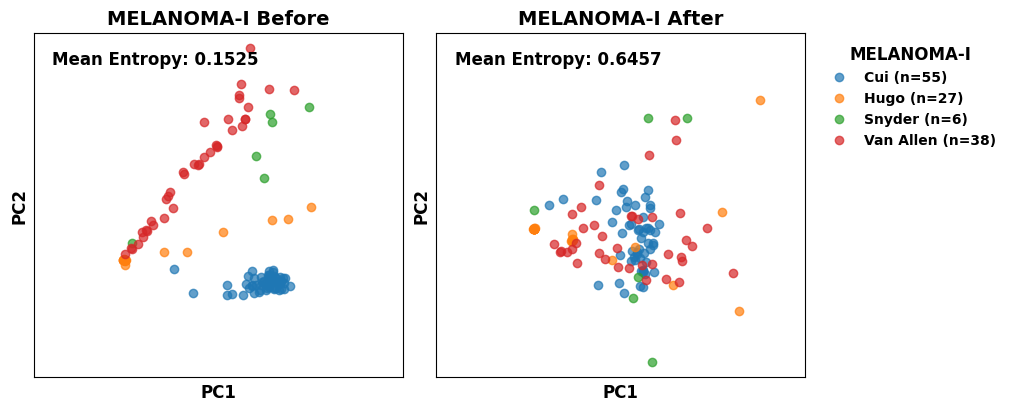

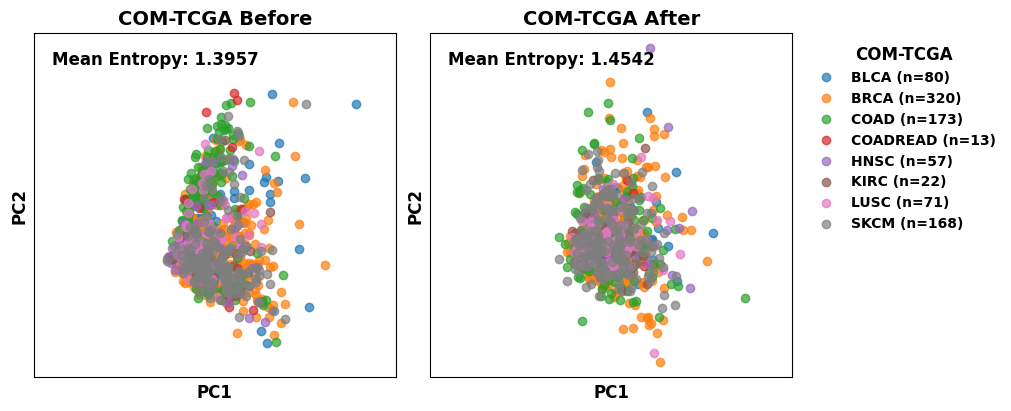

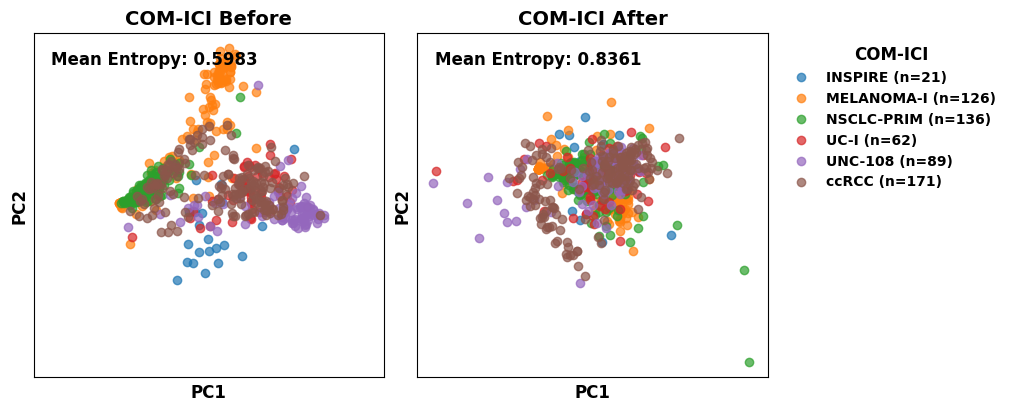

In [ ]:
### melanoma-I

fig1_1, ax1_1 = plt.subplots(1,2, figsize=(10, 4), sharey=True, constrained_layout=True)
batch_plot(ax1_1[0], melanoma_gene, melanoma_labels, name = "MELANOMA-I Before", xlim = [-80,80])
batch_plot(ax1_1[1], melanoma_gene_harmony, melanoma_labels, name = "MELANOMA-I After", xlim = [-80,80], legend = True)

### TCGA
fig1_2, ax1_2 = plt.subplots(1,2, figsize=(10, 4), sharey=True, constrained_layout=True)
batch_plot(ax1_2[0], tcga_norm_os, tcga_os_clin['batch'], name = "COM-TCGA Before", xlim = [-50,50])
batch_plot(ax1_2[1], tcga_os_combat, tcga_os_clin['batch'], name = "COM-TCGA After", xlim = [-50,50], legend = True)

### COM-ICI
fig1_3, ax1_3 = plt.subplots(1,2, figsize=(10, 4), sharey=True, constrained_layout=True)
batch_plot(ax1_3[0], combined_gene, combined_labels, name = "COM-ICI Before")
batch_plot(ax1_3[1], combined_gene_combat, combined_labels, name = "COM-ICI After", legend = True)

# fig1_1.savefig("Figs/batch_melanoma.svg", format="svg", bbox_inches="tight")
# fig1_2.savefig("Figs/batch_tcga.svg", format="svg", bbox_inches="tight")
# fig1_3.savefig("Figs/batch_comici.svg", format="svg", bbox_inches="tight")

#### Fig.2 (a)-(c)

In [ ]:
def HR_forest(ax, ax_table, cox_df, title, palette = ["#9DAEB6",  "#3D5C6F"]):

    mask = cox_df.index.get_level_values(0) == cox_df.index.get_level_values(1)
    hr_df = cox_df[mask].copy()

    hr_df = hr_df.rename(columns={
        'exp(coef)':           'HR',
        'exp(coef) lower 95%': 'lower95',
        'exp(coef) upper 95%': 'upper95',
    })

    # sig_scores = (hr_df.groupby(hr_df.index)['p']
    #   .apply(lambda ps: (ps < 0.05).any())
    #   .loc[lambda s: s]
    #   .index
    #   .tolist())
    #hr_df1 = hr_df[hr_df.index.isin(sig_scores)].copy()

    hr_df1 = hr_df.sort_values(by = 'HR', ascending=True)
    ci_wide = hr_df1.pivot(index='score', columns='regression', values='c-index')
    scores  = list(i[0] for i in hr_df1.index.unique().tolist())
    y_base  = np.arange(len(scores))
    y_map   = dict(zip(scores, y_base))

    # small vertical offsets so U/M points don’t sit on top of each other
    offsets = {'univariate': +0.10, 'multivariate': -0.10}

    # 2) Set up figure with two columns, shared y-axis
    # fig = plt.figure(figsize=(6, len(scores)*0.6 + 1))
    # gs  = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.05)

    # ax      = fig.add_subplot(gs[0, 0])        # forest plot
    # ax_table = fig.add_subplot(gs[0, 1], sharey=ax)  # c-index “table”

    # 3) Draw the forest
    for model, grp in hr_df1.groupby('regression'):
        y_vals   = [y_map[s] + offsets[model] for s in grp['score']]
        hr       = grp['HR']
        lo_err   = hr - grp['lower95']
        hi_err   = grp['upper95'] - hr

        ax.errorbar(
            hr, y_vals,
            xerr=[lo_err, hi_err],
            fmt='o',
            c = palette[0] if model == 'univariate' else palette[1],
            label=model.capitalize(),
            capsize=3
        )

    ax.axvline(1, color='lightgray', linestyle='--', lw=1)
    ax.set_yticks(y_base)
    ax.set_yticklabels(scores, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    #ax.set_xlim(-0.5, 2.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_xlabel("Log (HR) (95% CI)", fontsize=12, fontweight='bold')
    ax.legend(frameon=False, title="", loc = "lower right", fontsize=10, prop={'weight':'bold'},bbox_to_anchor=(1.15, 0.95))

    #ax_table.xaxis.set_visible(True)
    ax_table.xaxis.tick_top()                 # move ticks & labels to top
    ax_table.tick_params(axis="x", length=0)  # no little tick-marks

    # 3) Set your two column headers
    ax_table.set_xticks([0, 1])
    ax_table.set_xticklabels(
        ["Uni", "Multi"],
        ha="center",
        va="bottom",   # or "top" if you want the text sitting above the tick line
        fontsize=12, fontweight='bold'
    )
    # ax_table.text(0, len(scores)-0.5, "Uni C-index", ha='center', va='top')
    # ax_table.text(1, len(scores)-0.5, "Multi C-index", ha='center', va='top')

    for score, y in y_map.items():
        uni   = ci_wide.loc[score,'univariate']
        multi = ci_wide.loc[score,'multivariate']
        ax_table.text(0, y, f"{uni:.4f}",   ha='center', va='center', fontsize=10, fontweight='bold')
        ax_table.text(1, y, f"{multi:.4f}", ha='center', va='center', fontsize=10, fontweight='bold')

    ax_table.set_xlim(-0.5, 1.5)
    ax_table.set_title("C-index", fontsize=12, fontweight='bold')

    for loc in ['top','right']:
        ax.spines[loc].set_visible(False)

    # table: drop all spines
    for spine in ax_table.spines.values():
        spine.set_visible(False)
    ax_table.set_facecolor('none')
    ax_table.patch.set_visible(False)

    return ax, ax_table


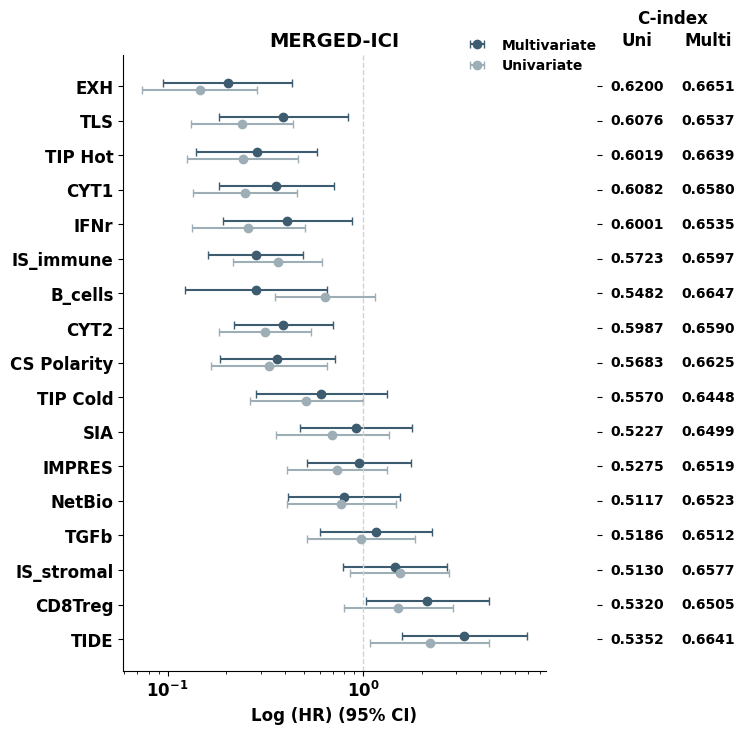

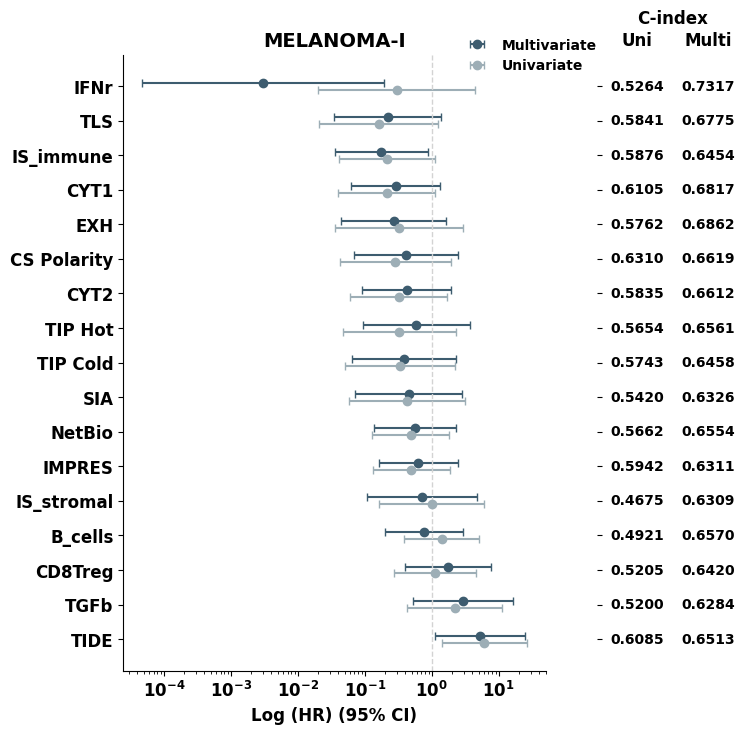

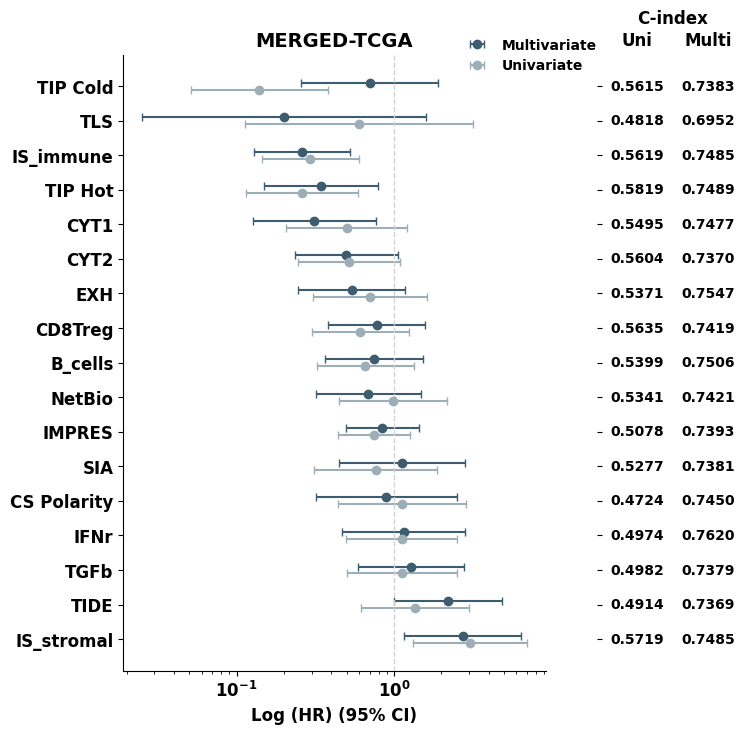

In [ ]:
fig2_1, ax2_1 = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,1], 'wspace':0.2},figsize=(8, 8))
HR_forest(ax2_1[0], ax2_1[1], cox_combined_df, "MERGED-ICI")

fig2_2, ax2_2 = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,1], 'wspace':0.2}, figsize=(8, 8))
HR_forest(ax2_2[0], ax2_2[1], cox_melanoma_df, "MELANOMA-I")

fig2_3, ax2_3 = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,1], 'wspace':0.2}, figsize=(8, 8))
HR_forest(ax2_3[0], ax2_3[1], cox_tcga_os_df, "MERGED-TCGA")

# fig2_1.savefig("Figs/forest_comici.svg", format="svg", bbox_inches="tight")
# fig2_2.savefig("Figs/forest_melanoma.svg", format="svg", bbox_inches="tight")
# fig2_3.savefig("Figs/forest_tcga.svg", format="svg", bbox_inches="tight")

#### Fig2. (e)-(f)

In [2221]:

def mwu_test(df, score_list, resp_col = "resp"):
    results = []
    for score in score_list:
        df1 = df.dropna(subset = score)
        r  = df1.loc[df1[resp_col]==1, score]
        nr = df1.loc[df1[resp_col]==0,score]
        U, p = stats.mannwhitneyu(r, nr, alternative='two-sided')
        rho, _ = spearmanr(df1[score], df1[resp_col])
        results.append({'score':score, 'U_stat':U, 'p_value':p, 'rho': rho})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value').reset_index(drop=True)
    return results_df


def box_resp(ax, df, scores, name, resp_col = "resp", col_palette = {"R": "#8BCBF1", "NR": "#498AC7"}):
    """ 
    Boxplots to compare the distribution of scores in responders vs non-responders
    """
    
    #fig, ax = plt.subplots(figsize = (len(scores)*1.5, 6))
    x = "score"
    y = "value"
    hue = "response"
    hue_order = ["R", "NR"]

    results_df = mwu_test(df, scores, resp_col)
    results_df = results_df.sort_values('p_value').reset_index(drop=True)
    order = results_df['score'].tolist()

    df1 = df.assign(response = df[resp_col].map({1:'R',0:'NR'})).melt(id_vars=['response'], 
            value_vars=scores,
            var_name='score', value_name='value')
    
    sns.boxplot(ax = ax, x=x, y=y, hue = hue, hue_order = hue_order, order = order, data=df1, fill = True, palette = col_palette, 
                showfliers = False)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="response")

    pairs = []
    for s in scores:
        pairs.append(((s, "R"), (s, "NR")))
    annotator = Annotator(ax, pairs, data = df1, x = x, y = y, order = scores, hue_order = hue_order, hue = hue)
    annotator.configure(test = "Mann-Whitney", text_format = "star", loc = 'inside', pvalue_thresholds=[
        [0.001, '****'],
        [0.01,  '***' ],
        [0.05,  '**'  ],
        [0.1,   '*'   ],
        [1,     'ns'  ]
    ])
    annotator.apply_and_annotate()

    ax.set_ylabel(name, weight = 'bold', size = 14)
    ax.set_yticklabels(np.round(ax.get_yticks(),2) ,weight = 'bold', size = 14)
    labels = ax.get_xticklabels()            # list of Text objects
    ax.set_xticklabels(labels, fontweight='bold', fontsize = 14, rotation = 90)
    ax.set_xlabel("")
    leg = ax.legend(frameon=True, title="", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, bbox_to_anchor = (1.1, 1))
    leg.get_title().set_fontweight('bold')
    for loc in ['top','right']:
        ax.spines[loc].set_visible(False)
        
    return ax

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       *: 5.00e-02 < p <= 1.00e-01
      **: 1.00e-02 < p <= 5.00e-02
     ***: 1.00e-03 < p <= 1.00e-02
    ****: p <= 1.00e-03

TGFb_R vs. TGFb_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:9.493e-01 U_stat=4.496e+04
IS_immune_R vs. IS_immune_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:4.130e-05 U_stat=5.421e+04
IS_stromal_R vs. IS_stromal_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:5.031e-01 U_stat=4.240e+04
NetBio_R vs. NetBio_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:2.904e-01 U_stat=4.738e+04
SIA_R vs. SIA_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:2.331e-02 U_stat=4.491e+04
TIDE_R vs. TIDE_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:2.027e-04 U_stat=3.570e+04
B_cells_R vs. B_cells_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:2.478e-04 U_stat=4.975e+04
CD8Treg_R vs. CD8Treg_NR: Mann-Whitney-Wilcoxon test two-sided, P_val:1.291e-01 U_stat=3.019e+04
IMPRES_R vs. IMPRES_NR: Mann-Whitney-Wilcoxo

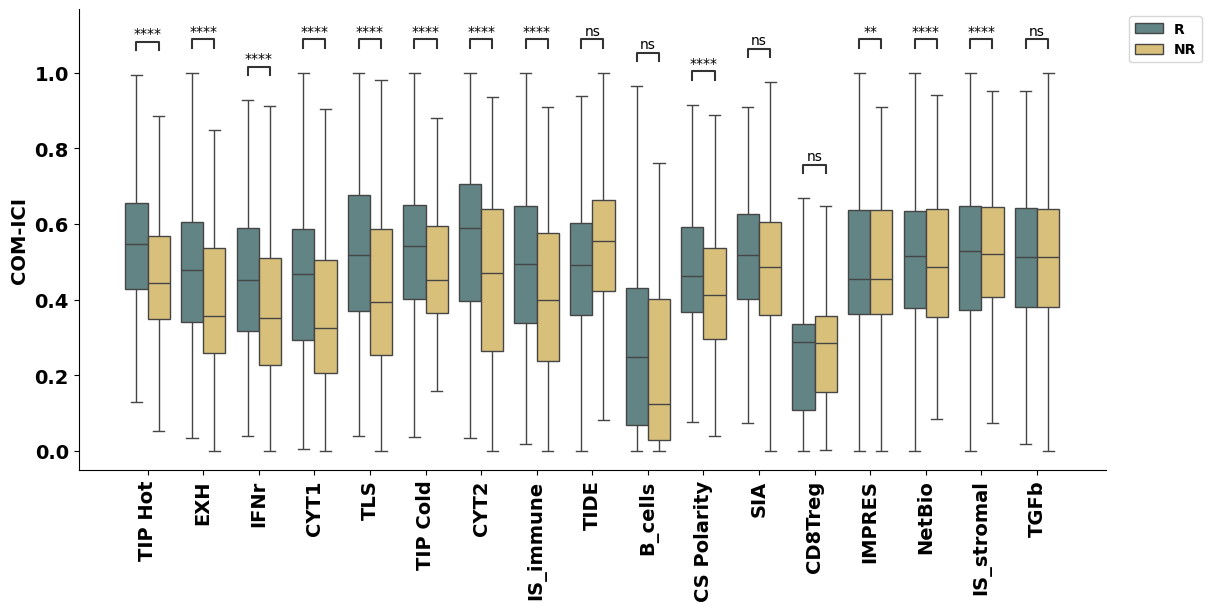

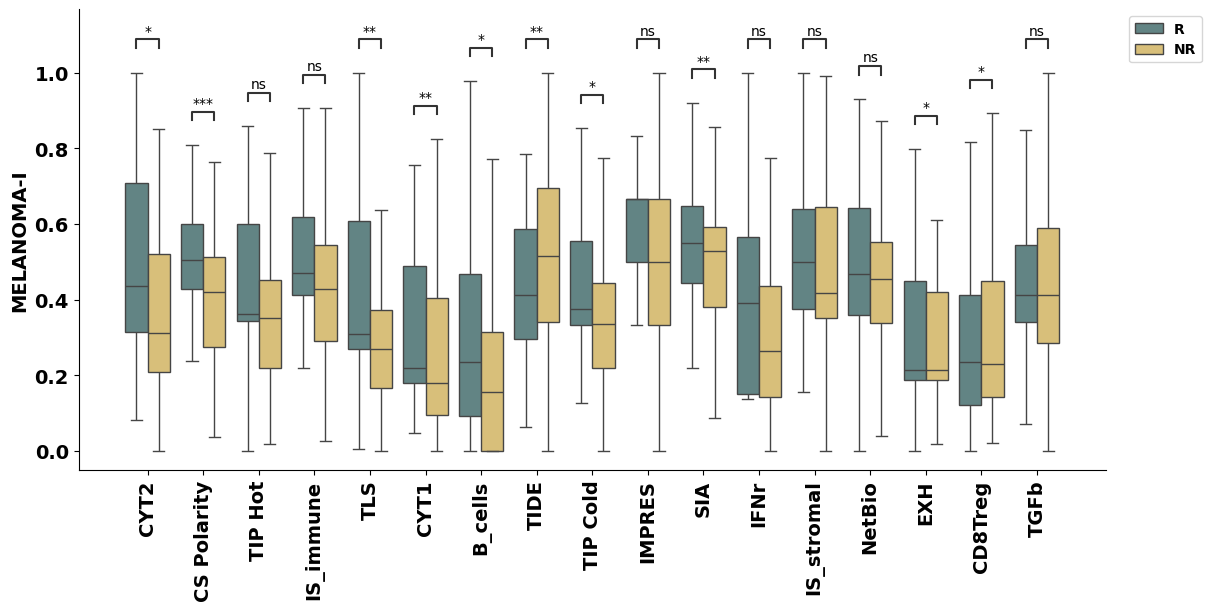

In [2225]:
fig2_4, ax2_4 = plt.subplots(figsize=(12, 6), constrained_layout=True)
box_resp(ax = ax2_4, df = combined_data1, scores = score_cols, name = "COM-ICI", col_palette = ["#5C8A8A", "#E7C66B"])

fig2_5, ax2_5 = plt.subplots(figsize=(12, 6), constrained_layout=True)
box_resp(ax = ax2_5, df = melanoma_data1, scores = score_cols, name = "MELANOMA-I", col_palette = ["#5C8A8A", "#E7C66B"])

fig2_4.savefig("Figs/box_comici.svg", format="svg", bbox_inches="tight")
fig2_5.savefig("Figs/box_melanoma.svg", format="svg", bbox_inches="tight")

##### Fig2. survival stackbar and violin plot (age)

In [ ]:
def survival_stack_bar(ax, df, category_col, cancer_type, event_col = "os_event", palette = ["#547AC0", "#898988"], legend = False):
    df1 = df.dropna(subset = [category_col, event_col])

    if category_col == "treatment":
        df1[category_col] = df1[category_col].map({"ctla4": 'CTLA-4', "pd1/pdl1": 'PD-1/PD-L1'})
    elif category_col == "gender" and cancer_type == "TCGA":
        df1[category_col] = df1[category_col].map({"male": 'M', "female": 'F'})

    df1['survival_status'] = df1[event_col].map({1: 'Dead', 0: 'Alive'})
    counts = pd.crosstab(df1[category_col], df1['survival_status'])
    props  = counts.div(counts.sum(axis=1), axis=0)
    table   = counts.values 
    _, p  = fisher_exact(table)
    if p < 0.001:
        star = '****'
    elif p < 0.01:
        star = '***'
    elif p < 0.05:
        star = '**'
    elif p < 0.1:
        star = '*'
    else:
        star = 'ns'

    ax = props.plot(kind='bar',stacked=True,color=palette,legend = False,edgecolor='black',ax=ax)

    for i, (_, row) in enumerate(counts.iterrows()):
        cum = 0
        total = row.sum()
        for status in counts.columns:
            value = row[status]
            if value == 0:
                continue
            percentage = value/total
            y = cum + percentage/2
            ax.text(
                i, y,
                str(value),
                ha='center', va='center',
                color='black',
                fontsize=12,
                fontweight='bold'
            )
            cum += percentage

    x1, x2 = 0, 1
    offset = 0.03
    y_line = 1 + offset
    # draw the line below the stars
    ax.plot([x1, x2],[y_line, y_line],lw=1.5,c='black')

    ax.text((x1 + x2) / 2,y_line + offset/2,star,ha='center',va='bottom',fontsize=12)

    ax.set_xlabel("")
    ax.set_ylabel(f"{cancer_type} {category_col.upper()}", weight = 'bold', size = 12)
    ax.set_title("")
    ax.set_ylim(0,1 + 2*offset)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, weight = 'bold', size = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(ax.get_yticklabels(), weight = 'bold', size = 12)
    if legend:
        leg = ax.legend(title="Survival Status", bbox_to_anchor=(1.02, 1), frameon=True, fontsize = 10, 
                  title_fontsize = 12, prop = {'weight':'bold'})
        leg.get_title().set_fontweight('bold')
        
    return ax


In [ ]:
def violin_age(ax, df, cancer_type, resp_col = "os_event"):
    df1 = df.dropna(subset = ["age", resp_col])
    df1['survival_status'] = df1[resp_col].map({1: 'Dead', 0: 'Alive'})
    sns.violinplot(ax = ax,x = 'survival_status',y  = 'age', data = df1, split= False,
                   scale= 'width', color = "grey", dodge = True, order = ['Alive','Dead'])

    annotator = Annotator(ax, [("Alive", "Dead")], data = df1, x = "survival_status", y = "age", 
                          order = ['Alive','Dead'])
    annotator.configure(test = "Mann-Whitney", line_height = 0, line_offset = 0.3, 
                        text_format = "star", loc = 'inside', pvalue_thresholds=[
        [0.001, '****'],
        [0.01,  '***' ],
        [0.05,  '**'  ],
        [0.1,   '*'   ],
        [1,     'ns'  ]])
    
    annotator.apply_and_annotate()
    ax.set_ylabel(f"{cancer_type} AGE", weight = 'bold', size = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, weight = 'bold', size = 12)
    ax.set_xlabel("")
    ax.set_yticklabels(ax.get_yticklabels(), weight = 'bold', size = 12)
    return ax

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       *: 5.00e-02 < p <= 1.00e-01
      **: 1.00e-02 < p <= 5.00e-02
     ***: 1.00e-03 < p <= 1.00e-02
    ****: p <= 1.00e-03

Alive vs. Dead: Mann-Whitney-Wilcoxon test two-sided, P_val:2.296e-03 U_stat=5.356e+04


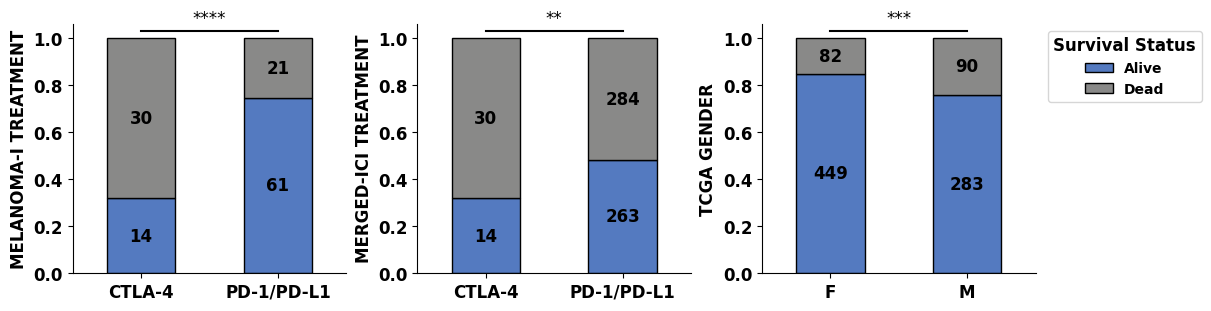

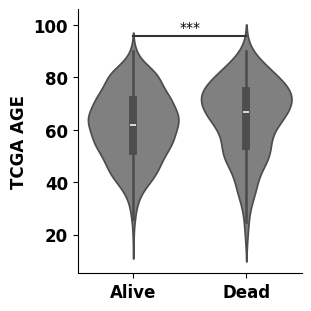

In [2199]:
fig2_6, ax2_6 = plt.subplots(1,3, figsize=(12, 3), constrained_layout=True)
survival_stack_bar(ax2_6[0], melanoma_data1, "treatment", "MELANOMA-I")
survival_stack_bar(ax2_6[1], combined_data1, "treatment", "MERGED-ICI")
survival_stack_bar(ax2_6[2], tcga_os_data1, "gender", "TCGA", legend = True)

fig2_7, ax2_7 = plt.subplots(figsize=(3, 3), constrained_layout=True)
violin_age(ax2_7, tcga_os_data1, cancer_type = "TCGA", resp_col = "os_event")

fig2_6.savefig("Figs/gender_trt_bar.svg", format="svg", bbox_inches="tight")
fig2_7.savefig("Figs/age_violin.svg", format="svg", bbox_inches="tight")

#### Fig. 3  AUCs

In [2140]:

def auc_plot(ax, df, name, resp_col = "resp", score_cols = score_cols, event_col = "os_event",
             show_sig = True, palette = "#1f77b4"):
    aucs = {}
    for col in score_cols:
        df1 = df.dropna(subset = [col, resp_col, event_col])
        df1 = df1[np.isfinite(df1[col])]
        aucs[col] = [roc_auc_score(df1[resp_col], df1[col]), roc_auc_score(df1[event_col], df1[col])]

    auc_df = pd.DataFrame({"score": list(aucs.keys()), "AUC-ICI": [x[0] for x in aucs.values()], "AUC-Survival": [x[1] for x in aucs.values()]})
    auc_df_sorted = auc_df.sort_values("AUC-ICI", ascending=False).reset_index(drop=True)

    if show_sig:
        auc_df_sorted = auc_df_sorted[auc_df_sorted["AUC-ICI"] > 0.5]
        ax.bar(auc_df_sorted["score"], auc_df_sorted["AUC-ICI"], color = palette)
        ax.set_ylim(0.5,0.8)   
        ax.grid(True, alpha = 0.3)
    else:
        auc_df_melted = auc_df.melt(id_vars=['score'], value_vars=['AUC-ICI', 'AUC-Survival'], 
                                    var_name='category', value_name='value')
        sns.barplot(data = auc_df_melted, x = 'score',
                    y = 'value',
                    hue = 'category', 
                    dodge= True, 
                    palette=palette, order = auc_df_sorted["score"],
                    ax = ax)
        ax.set_ylim(0,1)
        # ax.bar(auc_df_sorted["score"], auc_df_sorted["AUC"], color = palette)
        # ax.axhline(0.5, color="darkgray", linestyle="--", label="AUC = 0.5")
        # ax.set_ylim(0,0.8) 
        # ax.legend(frameon=False, loc = "upper right", fontsize=10, prop={'weight':'bold'})

    ax.set_xlabel("")
    ax.set_xticklabels(auc_df_sorted["score"], rotation=45, ha="right", fontsize=12, fontweight='bold')
    ax.set_ylabel("")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')
    ax.set_title(name, fontsize=14, fontweight='bold')
    leg = ax.legend(frameon=False, title="", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "upper right")
    leg.get_title().set_fontweight('bold')
    return ax, aucs, auc_df_sorted['score']


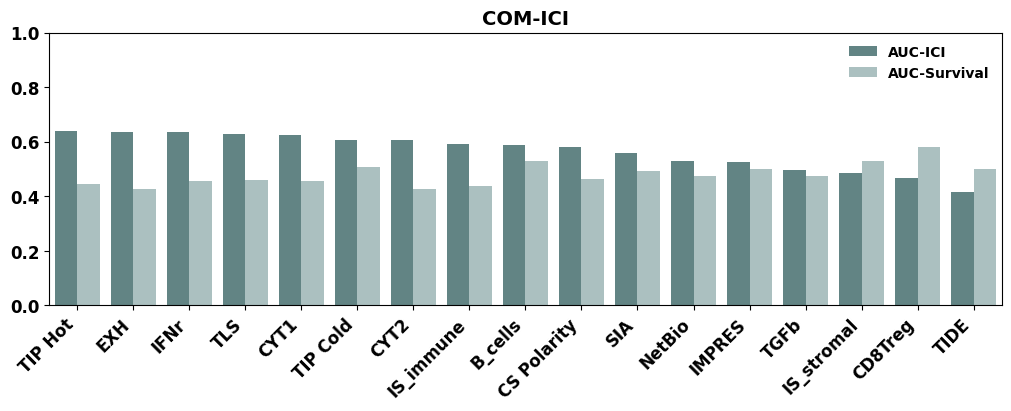

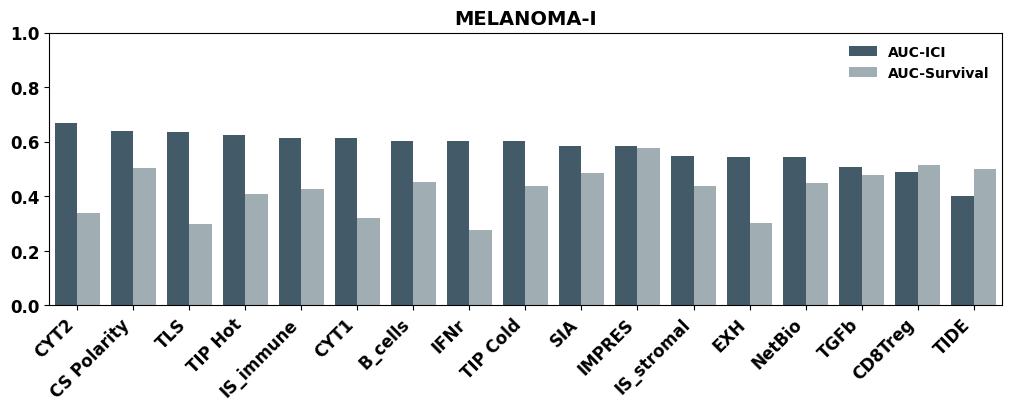

In [2141]:
fig3_1, ax3_1 = plt.subplots(figsize=(10, 4), constrained_layout=True)

_, aucs_raw, combined_order = auc_plot(ax3_1, combined_data1, name = "COM-ICI", 
                                       show_sig = False, palette=["#5C8A8A", "#A7C4C4"])

fig3_2, ax3_2 = plt.subplots(figsize=(10, 4), constrained_layout=True)
_, aucs_melanoma, melanoma_order = auc_plot(ax3_2, melanoma_data1, name = "MELANOMA-I", 
                                            show_sig=False, palette = ["#3D5C6F", "#9DAEB6"])

fig3_1.savefig("Figs/auc_comici.svg", format="svg", bbox_inches="tight")
fig3_2.savefig("Figs/auc_melanoma.svg", format="svg", bbox_inches="tight")

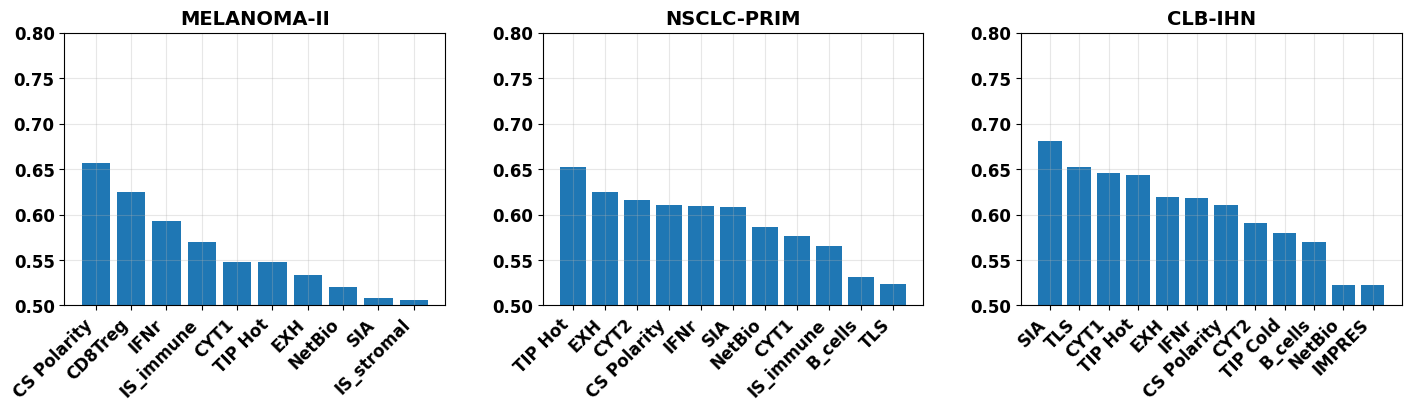

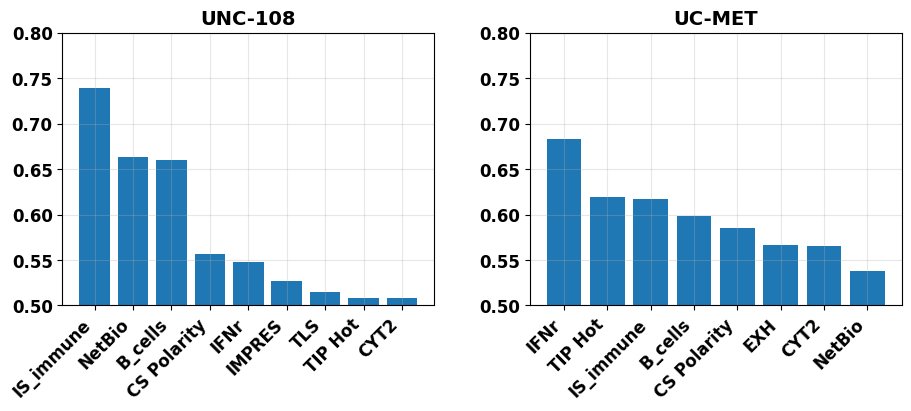

In [2159]:
# vath_data1['CB'] = vath_data1['clinical_benefit']
# ravi_data1['CB'] = ravi_data1['resp']
# foy_hnscc_data1['CB'] = foy_hnscc_data1['clinical_benefit']

fig3_3, ax3_3 = plt.subplots(1,3, figsize=(14, 4), constrained_layout=True, gridspec_kw={'wspace': 0.1})

_, aucs_vath,_ = auc_plot(ax3_3[0], df = vath_data, event_col = "os_status", name = "MELANOMA-II")
#_, aucs_ccrcc,_ = auc_plot(ax3_3[0,1], df = ccrcc_data, name = "ccRCC")
_, aucs_ravi,_ = auc_plot(ax3_3[1], df = ravi_data, name = "NSCLC-PRIM")
_, aucs_foy_hnscc,_ = auc_plot(ax3_3[2], df = foy_hnscc_data, event_col = "OS_status", name = "CLB-IHN")

fig3_4, ax3_4 = plt.subplots(1,2, figsize=(9, 4), constrained_layout=True, gridspec_kw={'wspace': 0.1})
_, aucs_urothelial_primary,_ = auc_plot(ax3_4[0], df = unc108_data1, name = "UNC-108")
#_, aucs_foy_nsclc,_ = auc_plot(ax3_4[0,1], df = foy_nsclc_data, event_col = "OS_event", name = "NIVOBIO")
_, aucs_urothelial_met,_ = auc_plot(ax3_4[1], df = urothelial_met_data, name = "UC-MET")

fig3_3.savefig("Figs/auc_ind1.svg", format="svg", bbox_inches="tight")
fig3_4.savefig("Figs/auc_ind2.svg", format="svg", bbox_inches="tight")

#### Fig. 4

In [1875]:
def km_survival(ax, df, time, delta, score_list, ylab, custom_palette = ["#547AC0", "#898988", "#F6C957"], sig = False):#["#3D5C6F", "#9DAEB6"]dark blue: "#6699CC"

    df1 = df[~df[delta].isna()]
    df1 = df1[~df1[time].isna()]
    kmf_H = KaplanMeierFitter()
    kmf_L = KaplanMeierFitter()

    n_score = len(score_list)
    ncol = 4
    nrow = (n_score+ncol-1)//ncol
    
    score_col = score_list+"_group"
    # Fit the model for each group
    kmf_H.fit(durations=df1[df1[score_col] == 'H'][time], event_observed=df1[df1[score_col] == 'H'][delta], label='H')
    kmf_L.fit(durations=df1[df1[score_col] == 'L'][time], event_observed=df1[df1[score_col] == 'L'][delta], label='L')

    n_H = df1[df1[score_col] == 'H'].shape[0]
    n_L = df1[df1[score_col] == 'L'].shape[0]
        
    # Plot the survival curves
    kmf_H.plot_survival_function(show_censors = True, color=custom_palette[0], ci_show=False, ax = ax)

    # kmf_M = KaplanMeierFitter()
    # kmf_M.fit(durations=df1[df1[score_col] == 'M'][time], event_observed=df1[df1[score_col] == 'M'][delta], label='M')
    # kmf_M.plot_survival_function(show_censors = True, color=custom_palette[2], ci_show=False, ax = ax)
    
    kmf_L.plot_survival_function(show_censors = True, color=custom_palette[1], ci_show=False, ax = ax)

    # perform log-rank test to the high and low groups
    df1[time] = pd.to_numeric(df1[time], errors='coerce')
    df1[delta] = pd.to_numeric(df1[delta], errors='coerce')
    results = logrank_test(df1[df1[score_col] == 'H'][time], df1[df1[score_col] == 'L'][time], 
                        event_observed_A=df1[df1[score_col] == 'H'][delta], event_observed_B=df1[df1[score_col] == 'L'][delta])

    # Add title and labels
    n = df1.shape[0]
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylim(0,1.1)
    xticks = ax.get_xticks()
    xticks_rounded = np.round(xticks, decimals=0)
    ax.set_xticklabels([f'{tick:.0f}' for tick in xticks_rounded], weight = 'bold', size = 14)
    ax.set_yticklabels(["0.0","0.2", "0.4", "0.6", "0.8", "1.0"] ,weight = 'bold', size = 14)

    ax.set_ylabel(score_list, fontsize = 12, fontweight = 'bold')
    if sig:
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 10, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold", color='darkred',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3', linewidth=1.5))
    else:
        ax.text(0.6, 0.95, f'P = {results.p_value:.4f}\nn = {n}\nn_H = {n_L}\nn_L = {n_H}', transform = ax.transAxes, 
            fontsize = 10, verticalalignment = 'top', horizontalalignment = 'left', fontweight = "bold")
    ax.get_legend().remove()

    ax.set_title(ylab, fontweight = 'bold', fontsize = 14)

    return ax, fig

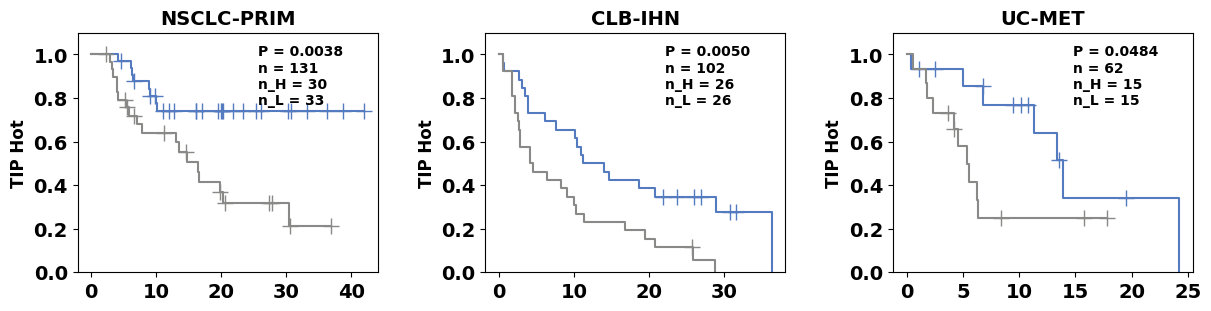

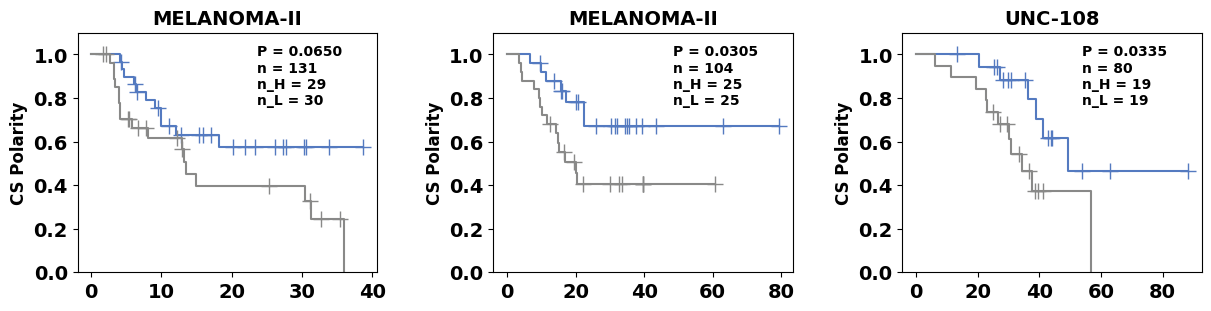

In [2171]:
### optimal score survival

vath_data1['os_months'] = vath_data1['os_days']/30

fig4_1, ax4_1 = plt.subplots(1,3, figsize=(12, 3), constrained_layout=True, gridspec_kw={'wspace': 0.1})

km_survival(ax4_1[0], ravi_data1, "os_months", "os_event", 'TIP Hot', "NSCLC-PRIM")
km_survival(ax4_1[1], foy_hnscc_data1, "OS_month", "OS_status", 'TIP Hot', "CLB-IHN")
km_survival(ax4_1[2], urothelial_met_data1, "os_months", "os_event", 'TIP Hot', "UC-MET")

fig4_2, ax4_2 = plt.subplots(1,3, figsize=(12, 3), constrained_layout=True, gridspec_kw={'wspace': 0.1})
km_survival(ax4_2[1], vath_data1, "os_months", "os_status", 'CS Polarity', "MELANOMA-II")
km_survival(ax4_2[2], unc108_data1, "os_months", "os_event", 'CS Polarity', "UNC-108")
km_survival(ax4_2[0], ravi_data1, "os_months", "os_event", 'CS Polarity', "MELANOMA-II")

fig4_1.savefig("Figs/surv_tiphot.svg", format="svg", bbox_inches="tight")
fig4_2.savefig("Figs/surv_cspolarity.svg", format="svg", bbox_inches="tight")

#### Fig4(c): volcano of MWU and response

In [2236]:
data_list = [vath_data1, ccrcc_data1, unc108_data1, urothelial_met_data1, foy_nsclc_data1, ravi_data1, foy_hnscc_data1]
name_list = ['MELANOMA-II', 'ccRCC', 'UNC-108', 'UC-MET', 'NIVOBIO', 'NSCLC-PRIM', 'CLB-IHN']

volcano_results = {}
for data, name in zip(data_list, name_list):
    volcano_results[name] = mwu_test(data, score_cols)
mwu_results_df = pd.concat(volcano_results, axis=0).reset_index()
mwu_results_df1 = mwu_results_df.rename(columns = {'level_0': 'cohort'})
mwu_results_df1 = mwu_results_df1.drop(columns = ['level_1'])
mwu_results_df1['neglog_p'] = -np.log10(mwu_results_df1['p_value'])


In [2446]:
def volcano_mwu(ax, df = mwu_results_df1): 

    df['label'] = "(" + df['cohort'] + ", " + df['score']+")"
    sig_df = df[df['p_value'] < 0.1]
    nonsig_df = df[df['p_value'] >= 0.1]

    sns.scatterplot(data = nonsig_df, x = 'rho', y = 'neglog_p', color = 'lightgrey', marker = "^",
        s = 80, edgecolors = None, linewidth = 1, ax = ax)

    sns.scatterplot(data = sig_df, x = 'rho', y = 'neglog_p', hue = 'cohort', marker = "^",
                    s = 80, edgecolors = None, linewidth = 1, palette = "Set2", ax = ax)

    for _, row in sig_df.iterrows():

        if row['score'] == "IS_immune" and row['cohort'] == "UNC-108":
            ax.annotate(row['score'], xy = (row['rho'], row['neglog_p']), xytext = (-70, -5),
                textcoords = 'offset points', ha = 'left', va = 'bottom', fontsize = 10, fontweight = 'bold')
        elif not (row['neglog_p'] < 2) & (row['rho'] < 0.27) & (row['rho'] > 0.13):
            ax.annotate(row['score'], xy = (row['rho'], row['neglog_p']), xytext = (5, -5),
                textcoords = 'offset points', ha = 'left', va = 'bottom', fontsize = 10, fontweight = 'bold')

    df_zoom = sig_df[(sig_df['neglog_p'] < 2) & (sig_df['rho'] < 0.27) & (sig_df['rho'] > 0.13)]

    # 3) compute bounds + padding
    x_min, x_max = df_zoom['rho'].min(), df_zoom['rho'].max()
    y_min, y_max = df_zoom['neglog_p'].min(), df_zoom['neglog_p'].max()

    pad_x = (x_max - x_min)*0.1  # 10% padding on each side
    pad_y = (y_max - y_min)*0.1

    x1, x2 = x_min - pad_x, x_max + pad_x
    y1, y2 = y_min - pad_y, y_max + pad_y

    axins = inset_axes(ax,
                    width=2.5, 
                    height=2.5,
                    #loc='upper right',
                    bbox_to_anchor=(0.6, 1),
                    bbox_transform=ax.transAxes)

    # 4) Plot the same data (or just the subset) into the inset
    sns.scatterplot(
        data = df,
            x    = 'rho',
            y    = 'neglog_p',
            hue  = 'cohort',
            marker = "^",
            s    = 80,
            palette = "Set2",
            ax   = axins,
            legend=False
        )
    # limit the view to your region of interest
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xlabel("")
    axins.set_ylabel("")
    # remove ticks if you like
    axins.set_xticks([])
    axins.set_yticks([])

    # 5) draw the “connector” lines between the inset and the main plot
    mark_inset(ax, axins,
            loc1=2, loc2=4,  linestyle="--",  # which corners to link
            fc="none", ec="grey", color = "grey")
    
    for _, row in df_zoom.iterrows():    # df_zoom is your significant subset
        if row['label'] in ["(CLB-IHN, TLS)", "(CLB-IHN, CYT1)", "(CLB-IHN, EXH)"]:
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (-15, 5),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 9,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        elif row['label'] == "(MELANOMA-II, CD8Treg)":
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (-20, -20),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 9,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        elif row['label'] == "(CLB-IHN, IFNr)":
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (5, 10),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 9,
                fontweight = 'bold',
                arrowprops = dict(
                    arrowstyle    = '->',
                    shrinkA       = 0.0,
                    shrinkB       = 0.2,
                    mutation_scale=10,
                    lw            = 0.8,
                    color         = 'black'
                )
            )
        else:
            axins.annotate(
                row['score'],
                xy         = (row['rho'], row['neglog_p']),
                xytext     = (-10, -10),           # offset in points
                textcoords = 'offset points',
                ha         = 'left',
                va         = 'bottom',
                fontsize   = 9,
                fontweight = 'bold'
            )

    ax.axvline(0,linestyle='--', color='darkred')
    ax.axhline(-np.log10(0.1),linestyle='--', color='darkred')
    ax.set_xlabel(r"Spearman $\rho$", fontsize=12, fontweight='bold')
    ax.set_ylabel('-log10(p-value)', fontsize=12, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

    leg = ax.legend(frameon=True, title="Cohort", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "upper left")
    leg.get_title().set_fontweight('bold')

    for spine in axins.spines.values():
        spine.set_edgecolor("grey")
        spine.set_linestyle("--")
        spine.set_linewidth(1.5)

    return ax



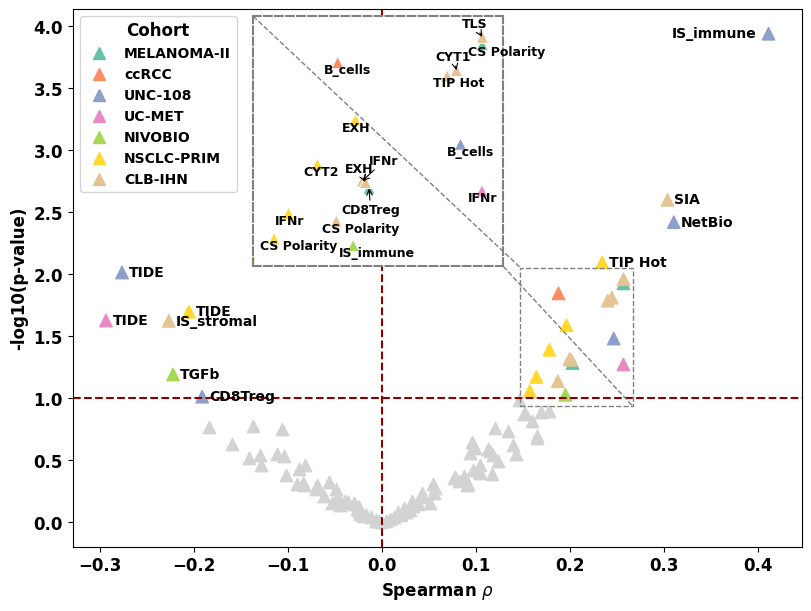

In [2447]:
fig4_3, ax4_3 = plt.subplots(figsize=(8, 6), constrained_layout=True)

volcano_mwu(ax4_3)
fig4_3.savefig("Figs/volcano_mwu.svg", format="svg", bbox_inches="tight")

##### Fig4(d): TCGA logrank volcano

In [ ]:
def batch_logrank(df, time_col = "os_months", event_col = "os_event", group_col = "cancer"):
    score_list = score_cols
    results = []
    groups = df[group_col].unique()
    df1 = df.copy()
    
    for g in groups:
        df_group = df1[df1[group_col] == g]
        if df_group.shape[0] <= 100:
            df_group1 = divide_group(df_group, half = True)
        else:
            df_group1 = divide_group(df_group)
        for score in score_list:
            try:
                df_group2 = df_group1.dropna(subset = [score])
                score_group = score + "_group"
                df_group3 = df_group2[df_group2[score_group]!= "M"]
                cph = CoxPHFitter(penalizer=0.1)
                df_group3['indicator'] = (df_group3[score_group] == "L").astype(int)
                cph.fit(df_group3[['indicator', time_col, event_col]], duration_col=time_col, event_col=event_col)
                row = cph.summary.loc['indicator']
                lower_ci = np.exp(row['coef lower 95%'])
                upper_ci = np.exp(row['coef upper 95%'])

                results.append({
                    "cancer":     g,
                    "score": score,
                    'n_total':     len(df_group3),
                    'n_H':         df_group3['indicator'].sum(),
                    'n_L': len(df_group3) - df_group3['indicator'].sum(),
                    'n_events':    df_group2[event_col].sum(),
                    'coef':        row['coef'],
                    'HR':          row['exp(coef)'],
                    'HR_lower95':  lower_ci,
                    'HR_upper95':  upper_ci,
                    'p_value':     row['p']
                })
            except:
                continue
    
    return pd.DataFrame(results)

logrank_results = batch_logrank(tcga_os_data)
#logrank_results.to_csv("logrank_tcga_results.csv")


In [ ]:


def volcano_logrank(ax, df = logrank_results):
    df['neg_log_p'] = -np.log10(df['p_value'])
    df['label'] = "(" + df['cancer'] + ", " + df['score']+")"
    sns.scatterplot(
        data = df[df['p_value'] >= 0.1],
        x    = 'HR',
        y    = 'neg_log_p',
        color = "lightgrey", 
        s       = 80,
        legend = False,
        ax = ax,
        edgecolor=None
    )

    sns.scatterplot(
        data = df[df['p_value'] < 0.1],
        x    = 'HR',
        y    = 'neg_log_p', palette = "deep",
        hue  = df['cancer'], 
        s       = 80,
        ax = ax,
        edgecolor=None
    )

    # 3) add threshold lines
    ax.axvline(1.0, color='darkred', ls='--')
    ax.axhline(-np.log10(0.1), color='darkred', ls='--')

    sig_df = df[df['p_value'] < 0.1]
    for _, row in sig_df.iterrows():
        if row['label'] in ["(SKCM, IS_immune)", "(SKCM, IS_stromal)"]:
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (-40, 10),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            arrowprops  = {
                'arrowstyle': '-',
                'lw': 0.8,     # line width
                'color': 'black',  # arrow color
                'shrinkA': 0.05,     # trims ends by 5%
            }
        )
        elif not (row['neg_log_p'] > 1) & (row['neg_log_p'] < 1.5) & (row['HR'] > 1):
            ax.annotate(
                row['score'],
                xy          = (row['HR'], row['neg_log_p']), 
                xytext      = (10, -10),                  
                textcoords  = 'offset points',
                ha          = 'left',
                va          = 'bottom',
                fontsize    = 10,
                fontweight = "bold",
            arrowprops  = {
                'arrowstyle': '-',
                'lw': 0.8,     # line width
                'color': 'black',  # arrow color
                'shrinkA': 0.05,     # trims ends by 5%
            }
            )

    df_zoom = sig_df[(sig_df['neg_log_p'] > 1) & (sig_df['neg_log_p'] < 1.7) & (sig_df['HR'] > 1)]

    # 3) compute bounds + padding
    x_min, x_max = df_zoom['HR'].min(), df_zoom['HR'].max()
    y_min, y_max = df_zoom['neg_log_p'].min(), df_zoom['neg_log_p'].max()

    pad_x = (x_max - x_min)*0.1  # 10% padding on each side
    pad_y = (y_max - y_min)*0.1

    x1, x2 = x_min - pad_x, x_max + pad_x
    y1, y2 = y_min - pad_y, y_max + pad_y

    axins = inset_axes(ax,
                    width=3, 
                    height=2.5,
                    #loc='upper right',
                    bbox_to_anchor=(0.65, 1),
                    bbox_transform=ax.transAxes)

    # 4) Plot the same data (or just the subset) into the inset
    sns.scatterplot(
        data = df,
            x    = 'HR',
            y    = 'neg_log_p',
            hue  = 'cancer',
            s    = 80,
            ax   = axins,
            legend=False
        )
    # limit the view to your region of interest
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xlabel("")
    axins.set_ylabel("")
    # remove ticks if you like
    axins.set_xticks([])
    axins.set_yticks([])

    # 5) draw the “connector” lines between the inset and the main plot
    mark_inset(ax, axins,
            loc1=2, loc2=4,  linestyle="--",  # which corners to link
            fc="none", ec="grey", color = "grey")
    
    for _, row in df_zoom.iterrows():    # df_zoom is your significant subset
        axins.annotate(
            row['score'],
            xy         = (row['HR'], row['neg_log_p']),
            xytext     = (-10, -10),           # offset in points
            textcoords = 'offset points',
            ha         = 'left',
            va         = 'bottom',
            fontsize   = 9,
            fontweight = 'bold',
            arrowprops = dict(
                arrowstyle    = '->',
                shrinkA       = 0.0,
                shrinkB       = 0.2,
                mutation_scale=10,
                lw            = 0.8,
                color         = 'black'
            )
        )

    handles, labels = ax.get_legend_handles_labels()
    wanted = set(sig_df['cancer'].unique())
    filt   = [(h,l) for h,l in zip(handles,labels) if l in wanted]

    # unpack and re-draw
    if filt:
        handles, labels = zip(*filt)
    else:
        handles, labels = [], []
    ax.set_xlabel('Hazard Ratio', fontsize=12, fontweight='bold')
    ax.set_ylabel('-log10(p-value)', fontsize=12, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
    ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')
    ax.set_title('')
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 5)
    leg = ax.legend(handles = handles, labels = labels, frameon=True, title="Cohort", title_fontsize = 12,
                        prop={'weight':'bold', 'size':10}, loc = "upper left")
    leg.get_title().set_fontweight('bold')

    for spine in axins.spines.values():
        spine.set_edgecolor("grey")
        spine.set_linestyle("--")
        spine.set_linewidth(1.5)

    return ax


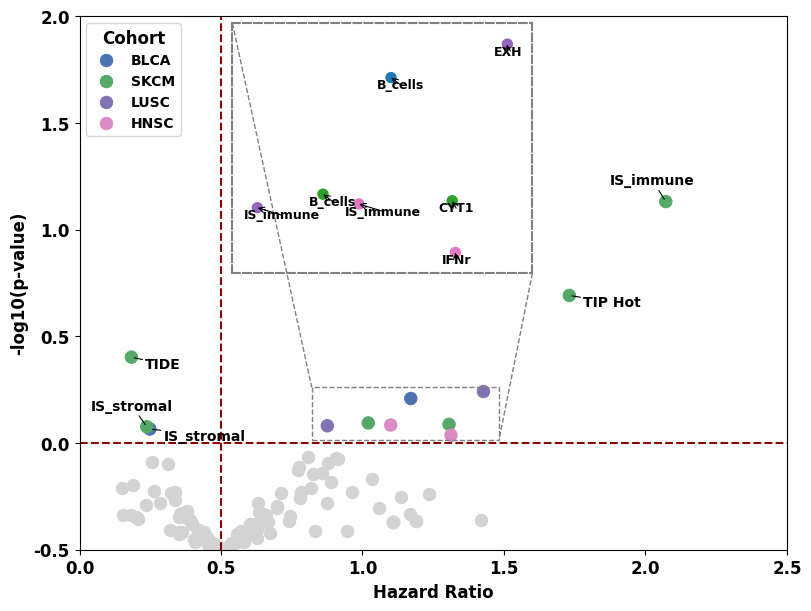

In [2387]:
fig4_4, ax4_4 = plt.subplots(figsize=(8, 6), constrained_layout=True)

volcano_logrank(ax4_4)
fig4_4.savefig("Figs/volcano_logrank.svg", format="svg", bbox_inches="tight")